# Visualize Simulated Boycott Results

In [150]:
from collections import defaultdict
import json

In [151]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="dark")
from scipy import stats

from scipy.interpolate import interp1d

NUM_USERS = 6040

First things first: let's load our master data file (a single, aggregated csv)
and take a glance at the data.

In [152]:
df = pd.read_csv('all_results.csv', dtype={'indices': str})
df.sample(5)

,Unnamed: 0,name,algo_name,indices,ratingfrac,userfrac,Unnamed: 0.1,fit_time_all,fit_time_all-like-boycott,fit_time_boycott,...,rmse_all-like-boycott,rmse_boycott,rmse_like-boycott,rmse_non-boycott,test_times_all,test_times_all-like-boycott,test_times_boycott,test_times_like-boycott,test_times_non-boycott,type
19228,320,4228 user sample,KNNBaseline_item_msd,501-to-750,1.0,1.0,0160_KNNBaseline_item_msd,8.121962,8.121962,8.121962,...,0.993393,0.993393,NaN,0.907215,58.591696,149.087488,124.457363,NaN,101.495497,sample_users
25229,321,5980 user sample,SVD,501-to-750,1.0,1.0,0160_SVD,0.799287,0.799287,0.799287,...,1.088753,1.088753,NaN,1.000553,52.099079,171.280345,111.473971,NaN,57.218387,sample_users
1461,53,1208 user sample,SVD,501-to-750,1.0,1.0,0026_SVD,60.732272,60.732272,60.732272,...,0.975322,0.975322,NaN,0.880676,46.964105,78.865536,76.151494,NaN,74.083998,sample_users
16548,140,3 user sample,KNNBaseline_item_msd,251-to-500,1.0,1.0,0070_KNNBaseline_item_msd,26.615219,26.615219,26.615219,...,0.861739,0.861739,NaN,0.885388,118.067909,236.542166,236.540977,NaN,234.840487,sample_users
25222,314,5980 user sample,KNNBaseline_item_msd,501-to-750,1.0,1.0,0157_KNNBaseline_item_msd,0.334378,0.334378,0.334378,...,1.078002,1.078002,NaN,0.990071,46.018925,152.943971,98.120147,NaN,48.955186,sample_users


Let's apply transformation that will affect the entire dataframe.
1. Calculate the number of users included in each experiment.

In [153]:
df = df.assign(num_users_boycotting = [NUM_USERS - int(x) for x in df.num_users])

Define all the lists that can be used throughout. By editing this cell we can easily modify the full notebook.

In [154]:
id_vars = ['name','algo_name', 'indices', 'ratingfrac', 'userfrac', 'num_ratings', 'num_users', 'num_users_boycotting']
metrics = [
    'rmse',
    'ndcg10',
    #'prec10t4',
    'ndcgfull',
]
organized_experiments = [
    'gender', 'age', 'state',
    'occupation', 'power', 'genre'
]
algo_names = ['KNNBaseline_item_msd', 'SVD']
standard_algo_names = ['KNNBaseline_item_msd', 'SVD', 'GlobalMean', 'MovieMean', 'GuessThree']
standard_results = {}
algo_to_metric_vs_global_mean = defaultdict(dict)
algo_to_metric_vs_movie_mean = defaultdict(dict)
algo_to_metric_vs_guess_three = defaultdict(dict)

for algo_name in standard_algo_names:
    filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
        'ml-1m', algo_name)
    with open(filename_ratingcv_standards, 'r') as f:
        standard_results[algo_name] = json.load(f)
for main_algo_name in algo_names:
    for metric in metrics:
        goodval = standard_results[main_algo_name][metric]
        gmean = standard_results['GlobalMean'][metric]
        mmean = standard_results['MovieMean'][metric]
        guess_three = standard_results['GuessThree'][metric]
        algo_to_metric_vs_global_mean[main_algo_name][metric] = (gmean - goodval) / goodval * 100
        algo_to_metric_vs_movie_mean[main_algo_name][metric] = (mmean - goodval) / goodval * 100
        algo_to_metric_vs_guess_three[main_algo_name][metric] = (guess_three - goodval) / goodval * 100
print(algo_to_metric_vs_global_mean)
print(algo_to_metric_vs_movie_mean)
print(algo_to_metric_vs_guess_three)

defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 26.212214327128592, 'ndcg10': -25.08885693794747, 'ndcgfull': -8.979990024568975}, 'SVD': {'rmse': 27.86669212136027, 'ndcg10': -25.19949040967044, 'ndcgfull': -9.068836408630688}})
defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 10.666579112406763, 'ndcg10': -2.3729399156465347, 'ndcgfull': -0.6626193653103807}, 'SVD': {'rmse': 12.117273870288884, 'ndcg10': -2.5171216775279754, 'ndcgfull': -0.7595844949992966}})
defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 42.29122522809577, 'ndcg10': -25.223311464690823, 'ndcgfull': -8.877753731208928}, 'SVD': {'rmse': 44.15647791943771, 'ndcg10': -25.333746365540698, 'ndcgfull': -8.96669991008485}})


In [155]:
algo_to_metric_to_slope = defaultdict(dict)
algo_to_metric_to_intercept = defaultdict(dict)
algo_to_metric_to_average_boycott = defaultdict(dict)


In [156]:
samples_df = df[df['type'] == 'sample_users']
print(samples_df[['num_users', 'num_users_boycotting']].sample(5))
org_df = df[df['type'].isin(organized_experiments)]

       num_users  num_users_boycotting
30302       6034                     6
17949       1812                  4228
850         4832                  1208
15207       2416                  3624
10903       5738                   302


In [157]:
org_df.name = [
    x.replace('excluded', '')
    .replace('users from', '')
    .replace('US_', '')
    .replace('state', '')
    .strip()
    for x in list(org_df.name)
]

C:\Users\Nick\Anaconda3\lib\site-packages\pandas\core\generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


First, let's see how well the # of ratings correlates with error
This will be an important piece of context for analyzing the experiments.

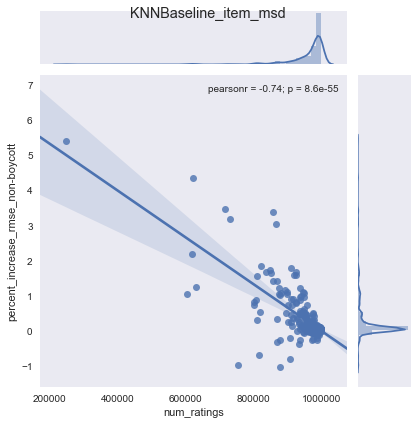

-6.65653006833e-06 6.64963473313 -0.742283000273 8.55492021854e-55
defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 11.922860514526235}})


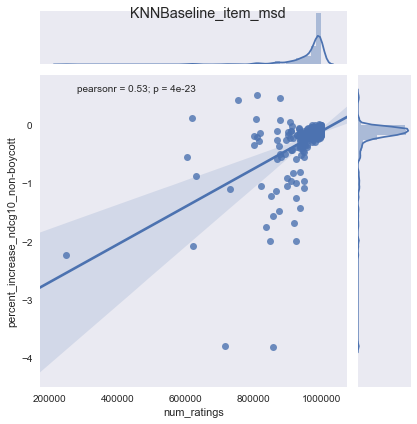

3.23925909635e-06 -3.34828242917 0.525450918893 4.04793828729e-23
defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 11.922860514526235, 'ndcg10': -2.831198830494514}})


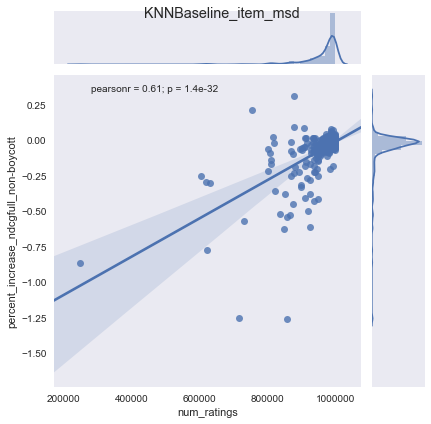

1.34760438979e-06 -1.35993838084 0.609967028376 1.43238086948e-32
defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 11.922860514526235, 'ndcg10': -2.831198830494514, 'ndcgfull': -0.8149080002475317}})


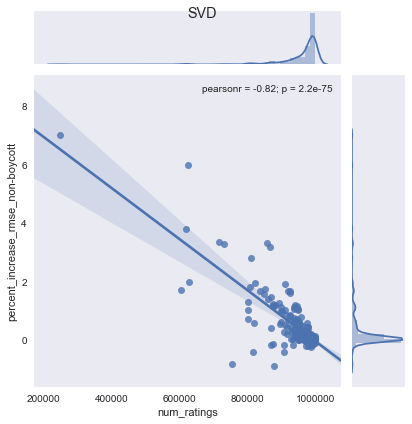

-8.70494146151e-06 8.66512922026 -0.819204470615 2.19068358134e-75
defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 11.922860514526235, 'ndcg10': -2.831198830494514, 'ndcgfull': -0.8149080002475317}, 'SVD': {'rmse': 13.351158759207092}})


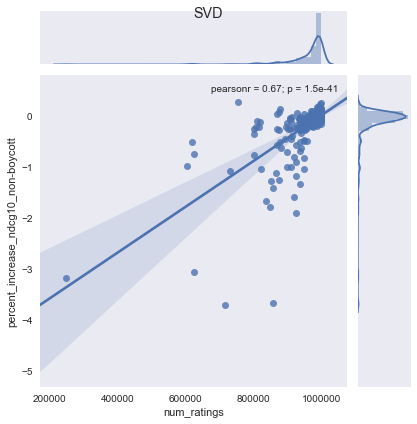

4.4792630306e-06 -4.47561325208 0.671914532406 1.54769894835e-41
defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 11.922860514526235, 'ndcg10': -2.831198830494514, 'ndcgfull': -0.8149080002475317}, 'SVD': {'rmse': 13.351158759207092, 'ndcg10': -3.2090039830092327}})


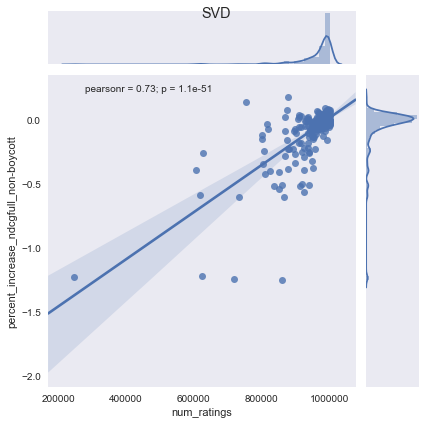

1.84892531026e-06 -1.82956613187 0.727542313421 1.12629990767e-51
defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 11.922860514526235, 'ndcg10': -2.831198830494514, 'ndcgfull': -0.8149080002475317}, 'SVD': {'rmse': 13.351158759207092, 'ndcg10': -3.2090039830092327, 'ndcgfull': -0.9705568968687147}})


In [158]:
for algo_name in algo_names:
    filt = org_df[org_df.algo_name == algo_name]
    for metric in metrics:
        key = 'percent_increase_{}_non-boycott'.format(metric)
        sns.jointplot(filt.num_ratings, y=filt[key], kind="reg").fig.suptitle(algo_name)
        plt.show()
        slope, intercept, r_value, p_value, std_err = stats.linregress(filt.num_ratings, y=filt[key])
        print(slope, intercept, r_value, p_value)
        algo_to_metric_to_slope[algo_name][metric] = slope
        algo_to_metric_to_intercept[algo_name][metric] = intercept
        
        # calculate the average error for all boycott users in each dataframe
        algo_to_metric_to_average_boycott[algo_name][metric] = np.mean(
            samples_df[(
                (samples_df.algo_name == algo_name) &
                (samples_df.userfrac == 1.0) & 
                (samples_df.ratingfrac == 1.0)
            )][key.replace('non-boycott', 'boycott')]
        )

        print(algo_to_metric_to_average_boycott)

In [159]:
# list(samples_df.columns.values)

In [160]:
def select_cols(cols, metrics, groups, percents):
    """ rename?"""
    increase_cols = [
        x for x in cols if (any(metric in x for metric in metrics) and 'increase' in x)
    ]
    increase_cols = [
        x for x in increase_cols if any(group == x.split('_')[-1] for group in groups)
    ]
    if percents:
        increase_cols = [x for x in increase_cols if 'percent' in x]
    else:
        increase_cols = [x for x in increase_cols if 'percent' not in x]
    print(increase_cols)
    return increase_cols

In [161]:
def fill_in_longform(df):
    """Fill in a longform dataframe with metric, group, and name information"""
    df = df.assign(
        metric=[x.split('_')[-2] for x in df.increase_type]
    )
    df = df.assign(
        group=[x.split('_')[-1] for x in df.increase_type]
    )
    return df
    

In [162]:
def p_b_curve(df, metrics, groups, percents=False, lm_plot=True, reg_plot=True):
    algo_to_metric_to_interp = defaultdict(dict)
    if lm_plot:
        increase_cols = select_cols(list(df.columns.values), metrics, groups, percents)
        longform = df[increase_cols + id_vars].melt(
            id_vars = id_vars,
            var_name='increase_type'
        )
        longform = fill_in_longform(longform)
        
#         plot1 = sns.lmplot(
#             x="num_users_boycotting", y="value", hue="algo_name", data=longform,
#             size=6, row='metric',
#             order=2,
#         )
#         if percents:
#             plot1.set_ylabels("percent increase")
#         else:
#             plot1.set_ylabels("increase")
#        plot1.set_xlabels('Percent of Users')
        
        sns.lmplot(
            x="num_users_boycotting", y="value", hue="algo_name", data=longform,
            size=6, row='metric',
            fit_reg=False, x_estimator=np.mean
        )
        # CALC LOG PLOT
#         vals = [float(x) for x in list(longform.value)]
#         minval = np.min(vals)
#         shifted = vals + - minval + 0.00001
#         print(np.min(shifted))
#         longform = longform.assign(logy = np.log2(shifted))
#         g = sns.lmplot(
#             x="num_users_boycotting", y="logy", hue="algo_name", data=longform,
#             size=6, row='metric',
#             x_estimator=np.mean,
#             order=2
#         )
    
    for metric in metrics:
        for algo_name in algo_names:
            filt = df[df.algo_name == algo_name]
            key = 'increase_{}_non-boycott'.format(metric)
            if percents:
                key = 'percent_' + key
            x = filt.num_users_boycotting
            user_nums = list(set(filt.num_users_boycotting))
            y = filt[key]
            
            num_to_mean = {}
            for num_users_boycotting in user_nums:
                filt_by_name = filt[filt.num_users_boycotting == num_users_boycotting]
                num_to_mean[num_users_boycotting] = np.mean(filt_by_name[key])
            meany = np.array(list(num_to_mean.values()))
            
            smoothf = interp1d(user_nums, meany, kind='cubic', bounds_error=False, fill_value='extrapolate')
            algo_to_metric_to_interp[algo_name][metric] = smoothf
            xnew = np.linspace(min(user_nums), max(user_nums), num=500)
            if reg_plot:
                _, ax = plt.subplots()
                g = sns.regplot(
                    x=x, y=y,
                    x_estimator=np.mean,
                    x_bins=user_nums,
                    ax=ax,
                    ci=99,
                    fit_reg=False,
                )
                g.set_title(algo_name)
                
                plt.plot(xnew, smoothf(xnew), '-')
                plt.axhline(0, color='0.5', linestyle='--')
                plt.axhline(algo_to_metric_vs_movie_mean[algo_name][metric], color='0.5', linestyle='--')

    return algo_to_metric_to_interp


Working through log plots
y = log(x)
y = e ^ x
ln(y) = x

['percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_non-boycott']


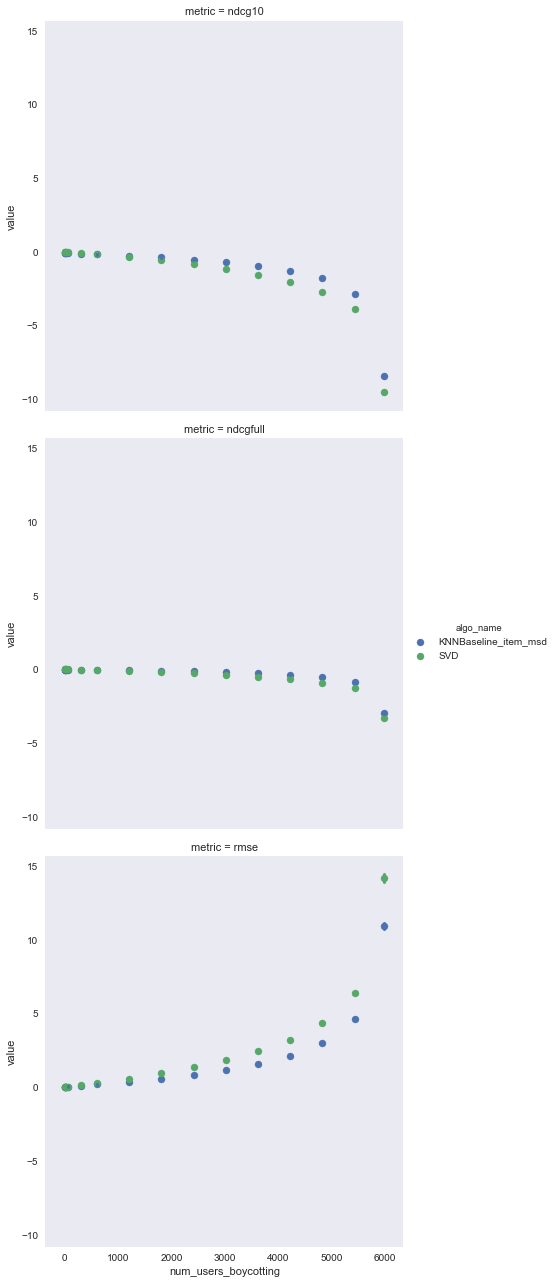

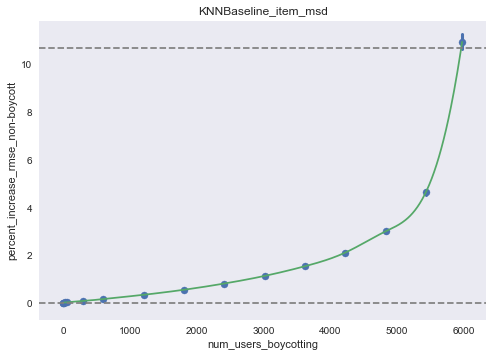

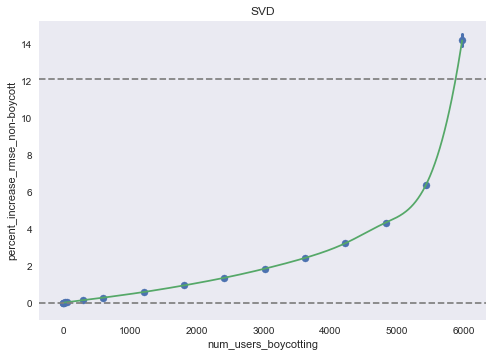

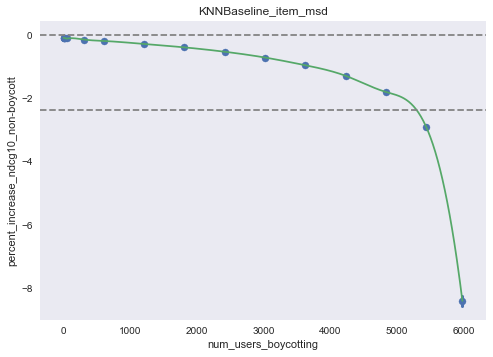

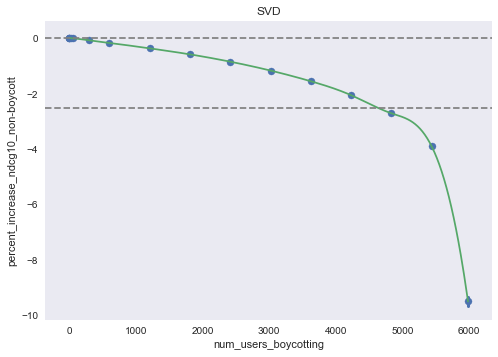

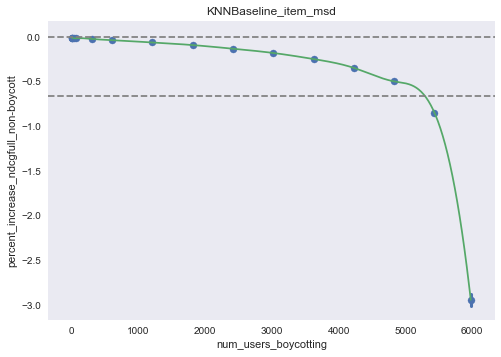

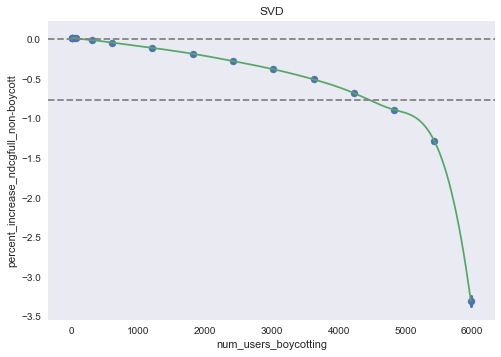

In [163]:
algo_to_metric_to_interp = p_b_curve(
    samples_df,
    metrics=metrics,
    percents=True,
    groups=['non-boycott',]
)
plt.show()

['percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_non-boycott']


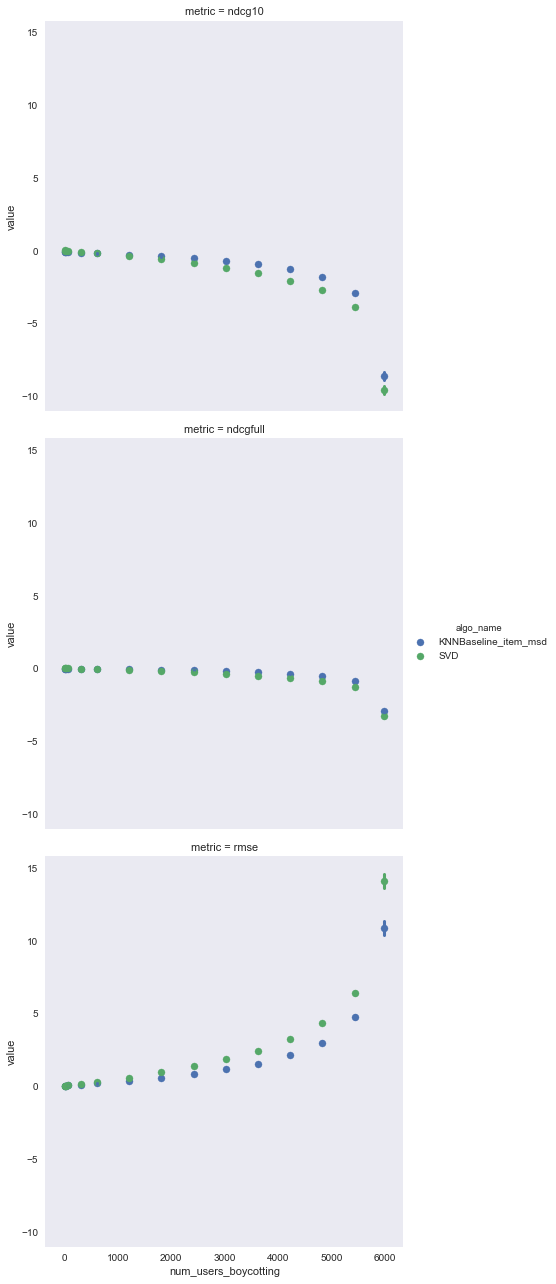

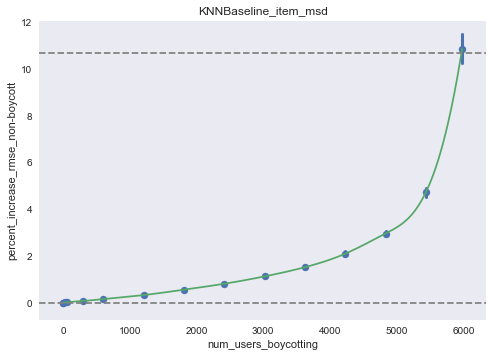

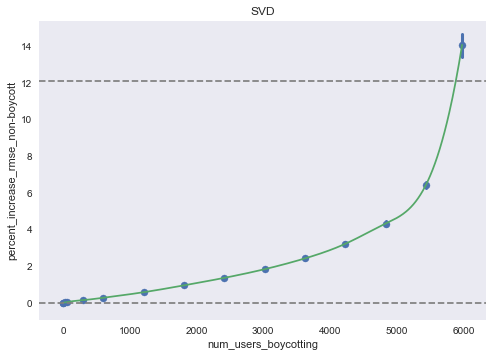

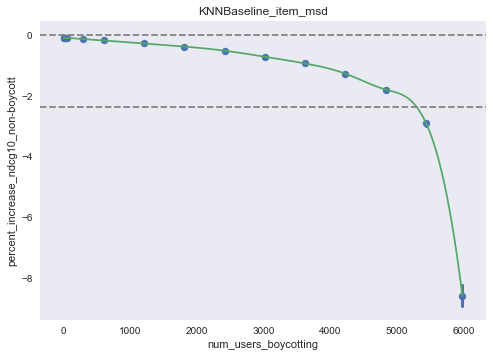

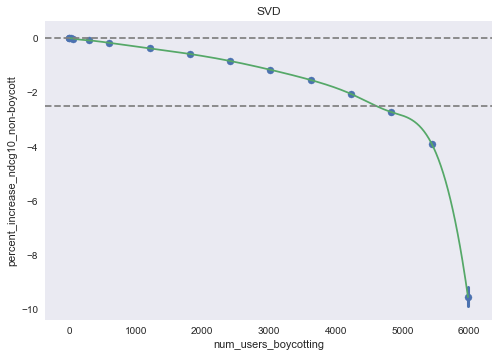

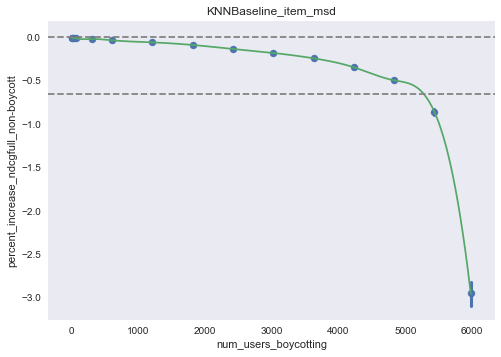

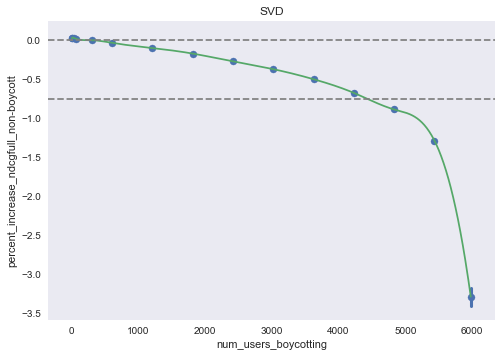

In [164]:
algo_to_metric_to_interp = p_b_curve(
    samples_df[samples_df.indices == '1-to-250'],
    metrics=metrics,
    percents=True,
    groups=['non-boycott',]
)
plt.show()

In [165]:
for metric in metrics:
    for algo_name in algo_names:
        key = 'percent_increase_{}_expected'.format(metric)
        expected_vals = algo_to_metric_to_interp[algo_name][metric](org_df.num_users_boycotting)
        print(key)
        kwargs = {key: expected_vals}
        org_df = org_df.assign(**kwargs)

percent_increase_rmse_expected
percent_increase_rmse_expected
percent_increase_ndcg10_expected
percent_increase_ndcg10_expected
percent_increase_ndcgfull_expected
percent_increase_ndcgfull_expected


In [166]:
# Use this cell to show raw values instead of percents.

# g = plot1(
#     samples_df,
#     metrics=['rmse', 'ndcg', 'prec'],
#     percents=False,
#     groups=['non-boycott', 'all',]
# )
# plt.show()

In [167]:
algo_to_metric_vs_movie_mean

defaultdict(dict,
            {'KNNBaseline_item_msd': {'ndcg10': -2.3729399156465347,
              'ndcgfull': -0.6626193653103807,
              'rmse': 10.666579112406763},
             'SVD': {'ndcg10': -2.5171216775279754,
              'ndcgfull': -0.7595844949992966,
              'rmse': 12.117273870288884}})

In [168]:
def plot2(df, metrics, groups, percents=False, kind='bar', size=10):
    increase_cols = select_cols(list(df.columns.values), metrics, groups, percents)
    longform = df[increase_cols + id_vars].melt(
        id_vars = id_vars,
        var_name='increase_type'
    )
    longform = fill_in_longform(longform)
    longform = longform.assign(
        name_plus_ratings=['{} ({}k)'.format(
            name, int(round(num_ratings/1000,0))
        ) for name, num_ratings in zip(longform.name, longform.num_ratings)
    ])
    g = sns.factorplot(
        x="value", y="name", hue="group", data=longform,
        size=size, kind=kind, col='algo_name', row='metric',
        sharex=False,
        # linestyles='None',
        # capsize=0.1
    )
    a = g.axes
    
    # flag: hardcoded right now. Not good.
    # use .facet_data() ?
    algo_order = ['KNNBaseline_item_msd', 'SVD']
    metric_order = ['ndcg10', 'ndcgfull', 'rmse']
    for y in range(a.shape[0]):
        for x in range(a.shape[1]):
            val = algo_to_metric_vs_movie_mean[algo_order[x]][metric_order[y]]
            g.axes[y,x].axvline(0, color='0.5', linestyle='--')
            g.axes[y,x].axvline(val, color='0.5', linestyle='--')
    return g


In [169]:
state_boycotts = org_df[org_df['type'] == 'state']
gender_boycotts = org_df[org_df['type'] == 'gender']
age_boycotts = org_df[org_df['type'] == 'age']
occupation_boycotts = org_df[org_df['type'] == 'occupation']
power_boycotts = org_df[org_df['type'] == 'power']
genre_boycotts = org_df[org_df['type'] == 'genre']

In [170]:
def all_users_all_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 1.0)
    )]

In [171]:
def half_users(df):
    return df[(
        (df.userfrac == 0.5) & (df.ratingfrac == 1.0)
    )]

In [172]:
def half_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 0.5)
    )]

In [173]:
def plot_all_three_scenarios(df, size=6):
    plot2(
        all_users_all_ratings(df),
        metrics=metrics,
        percents=True,
        groups=['non-boycott', 'expected'],
        size=size
    ).fig.suptitle('All Users, All Ratings')
    plot2(
        half_users(df),
        metrics=metrics,
        percents=True,
        groups=['non-boycott', 'boycott', 'like-boycott', 'expected'],
        size=size
    ).fig.suptitle('Half Users')
    plot2(
        half_ratings(df),
        metrics=metrics,
        percents=True,
        groups=['non-boycott', 'boycott', 'like-boycott', 'expected'],
        size=size,
    ).fig.suptitle('Half Ratings')
    plt.show()

## Let's do gender first...

['percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']
['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_like-boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_boycott', 'percent_increase_ndcgfull_like-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_like-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']
['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_like-boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_boycott', 'percent_increase_ndcgfull_like-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_like-boycott', 'percent_increase

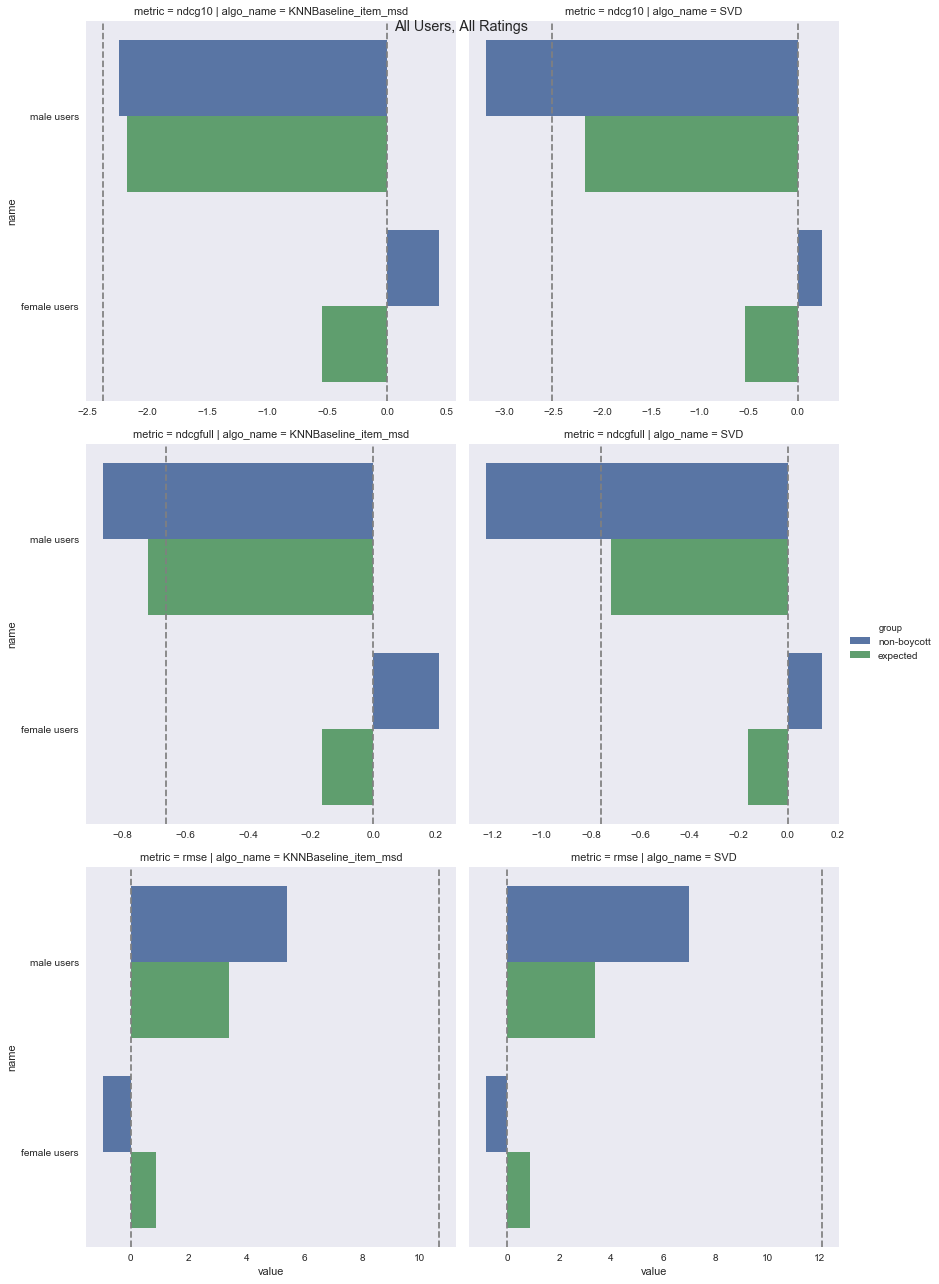

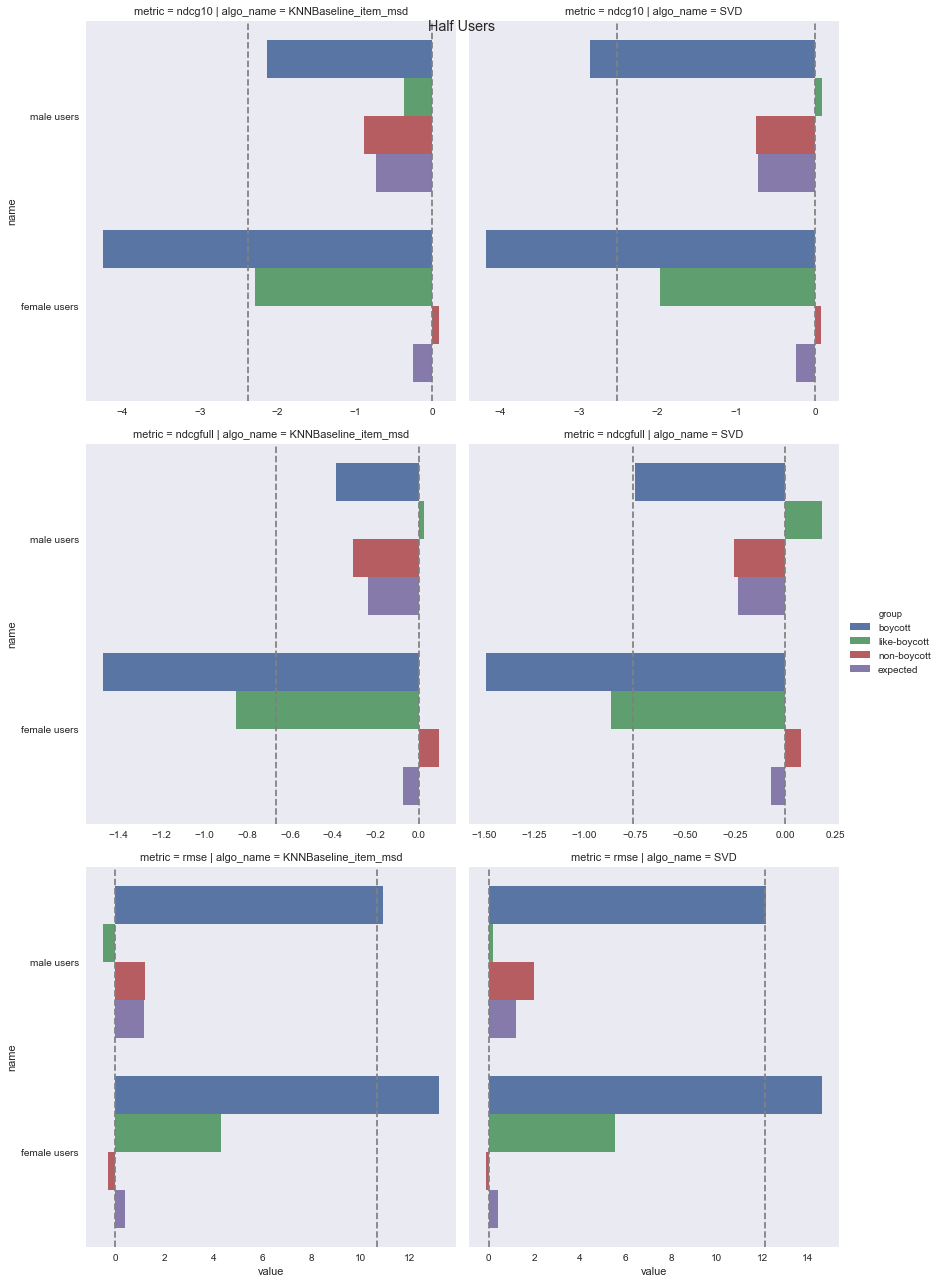

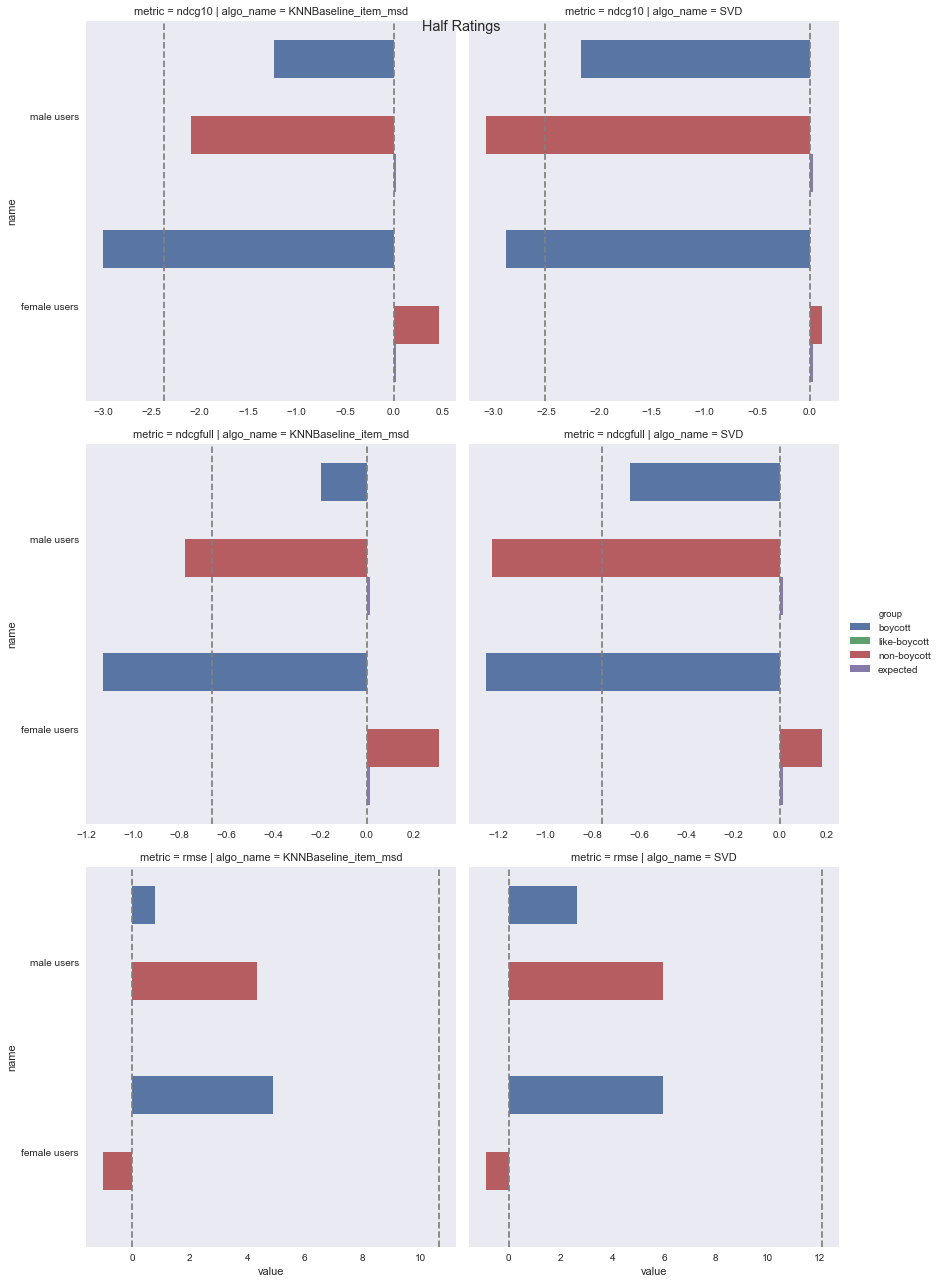

In [174]:
plot_all_three_scenarios(gender_boycotts)

States seemed interesting and slowed the page down a bit, so I commented out for now.
Main conclusion was that state-based boycotts seem to be pretty ineffective for basically every state.
One funny result was that it seems California users have especially low-value ratings - the performance degradation was quite off from the expected degradation (b/c CA has a lot of users).

In [175]:
# plot_all_three_scenarios(state_boycotts, size=12)

Below, the power boycotts show a very weird results. Warrants double checks.

It appears for KNN, removing all power users actually improves performance (as opposed to the large expected drop).
But at the same time, RMSE increases! This is one of the example where RMSE and NDCG do not correlate...

Note the artifact in plot #5 below: it looks like ndcg has a huge increase when bottom 10% users do a half boycott... but this is b/c ndcg@10 is just getting easier to "succeed" for these users

['percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']
['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_like-boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_boycott', 'percent_increase_ndcgfull_like-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_like-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']
['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_like-boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_boycott', 'percent_increase_ndcgfull_like-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_like-boycott', 'percent_increase

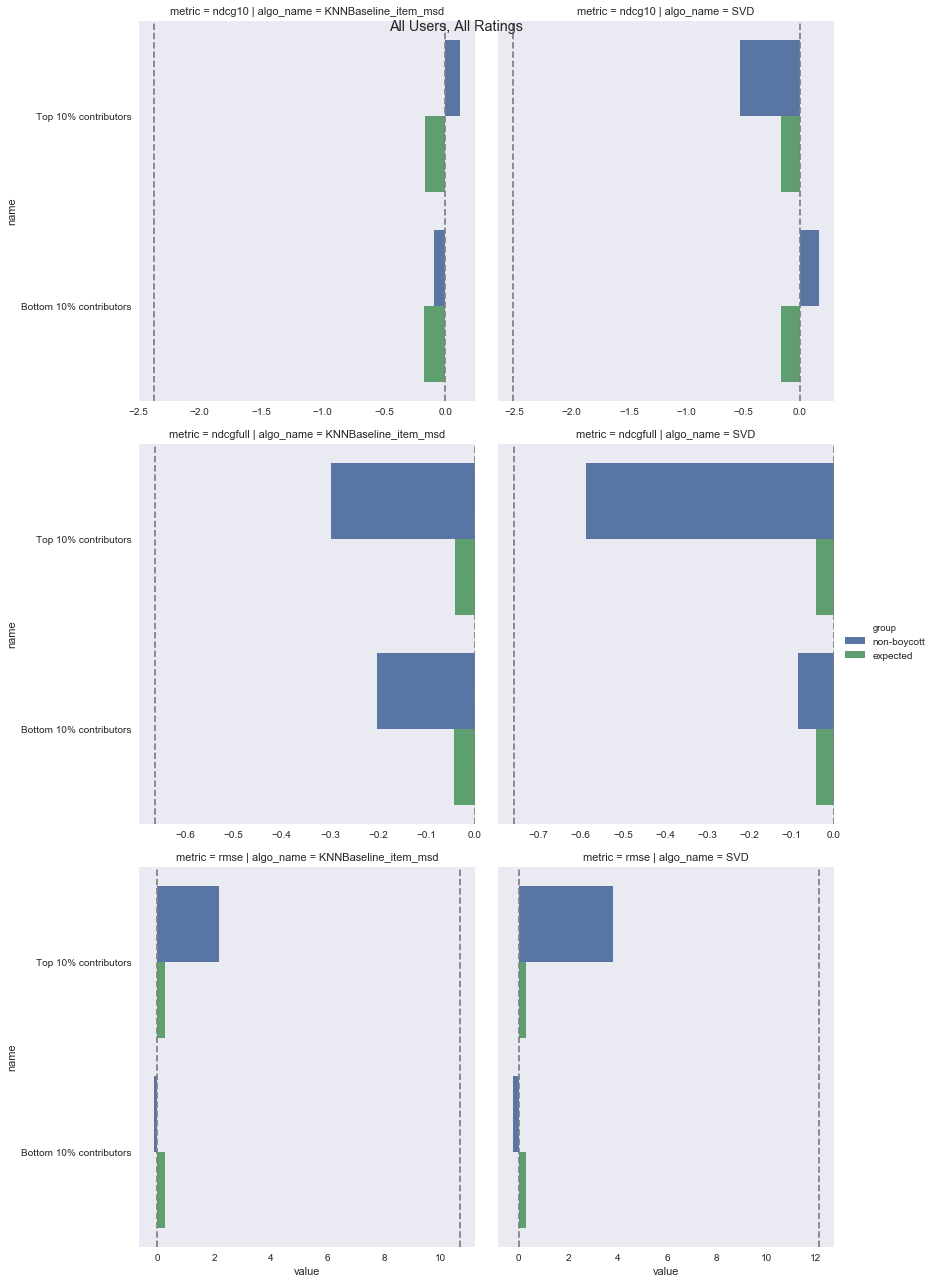

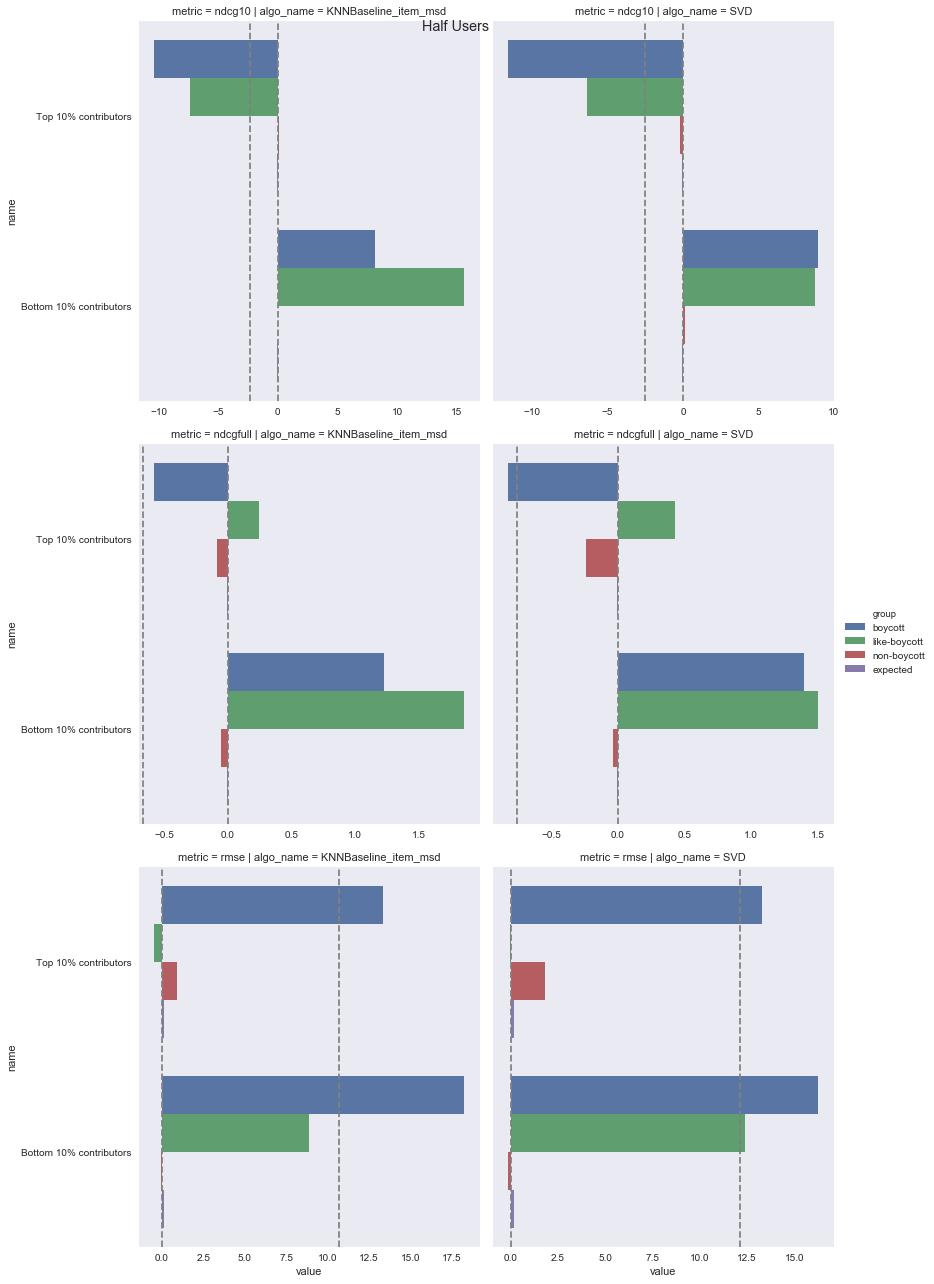

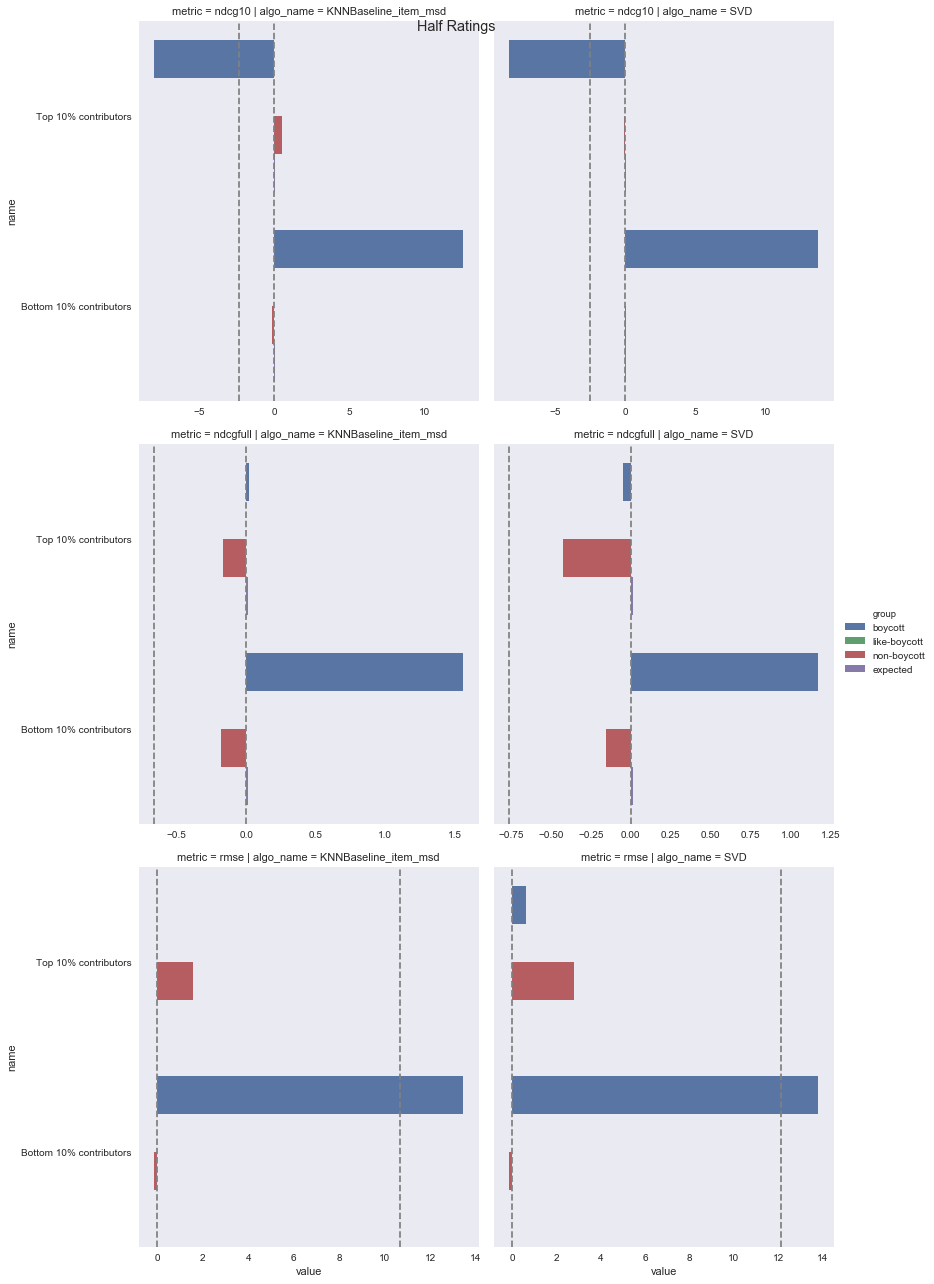

In [176]:
plot_all_three_scenarios(power_boycotts)

['percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']
['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_like-boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_boycott', 'percent_increase_ndcgfull_like-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_like-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']
['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_like-boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_boycott', 'percent_increase_ndcgfull_like-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_like-boycott', 'percent_increase

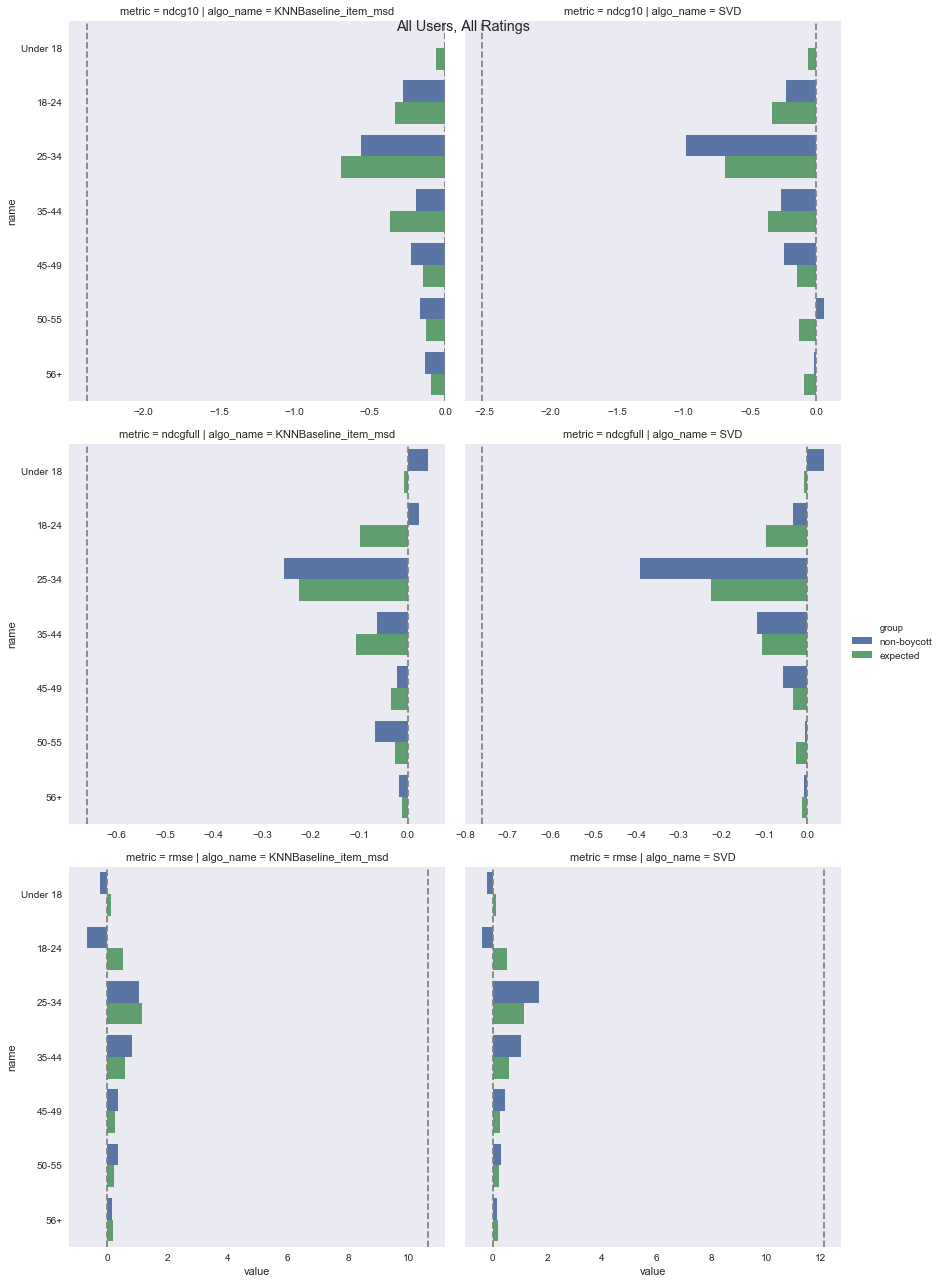

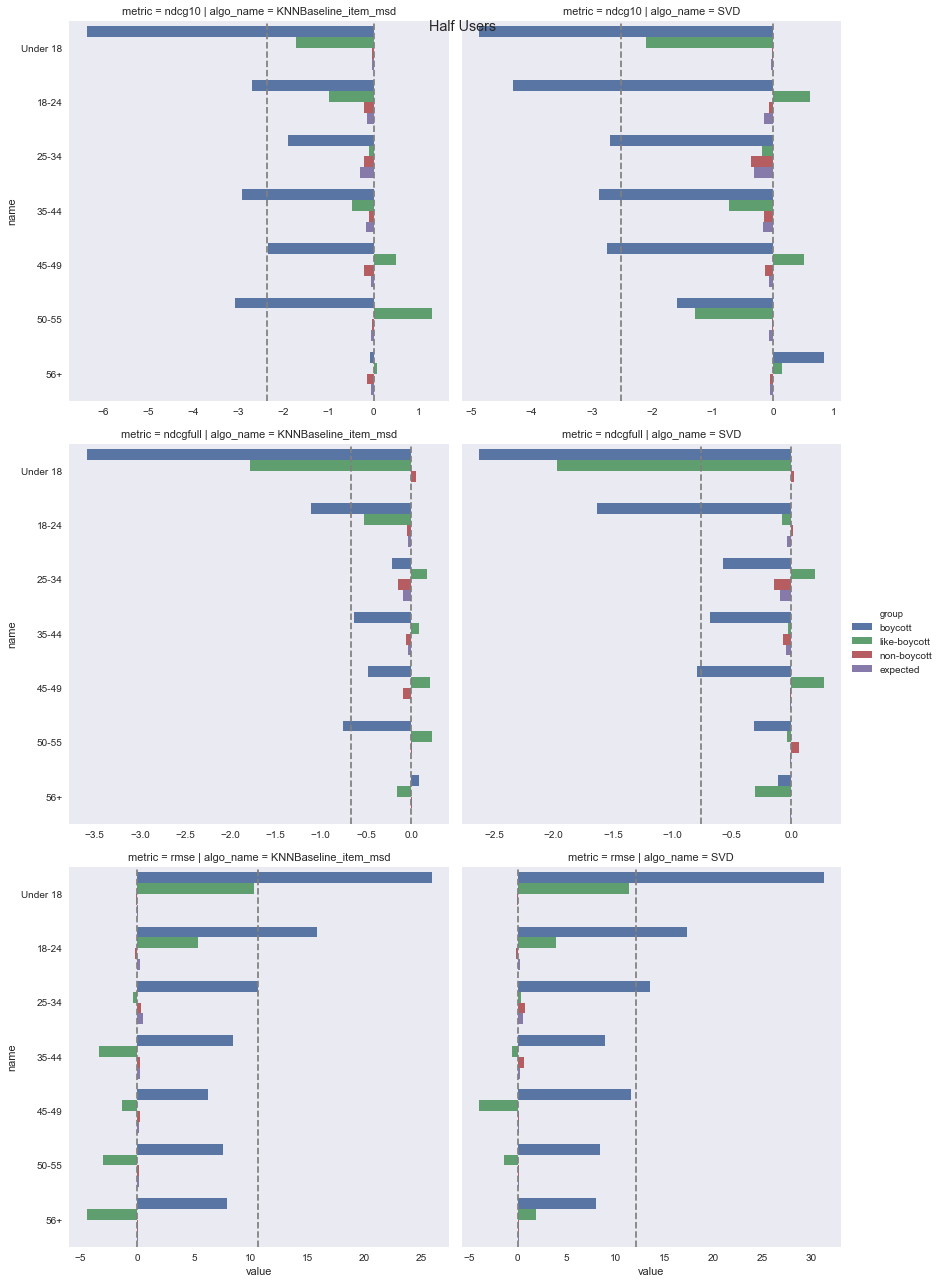

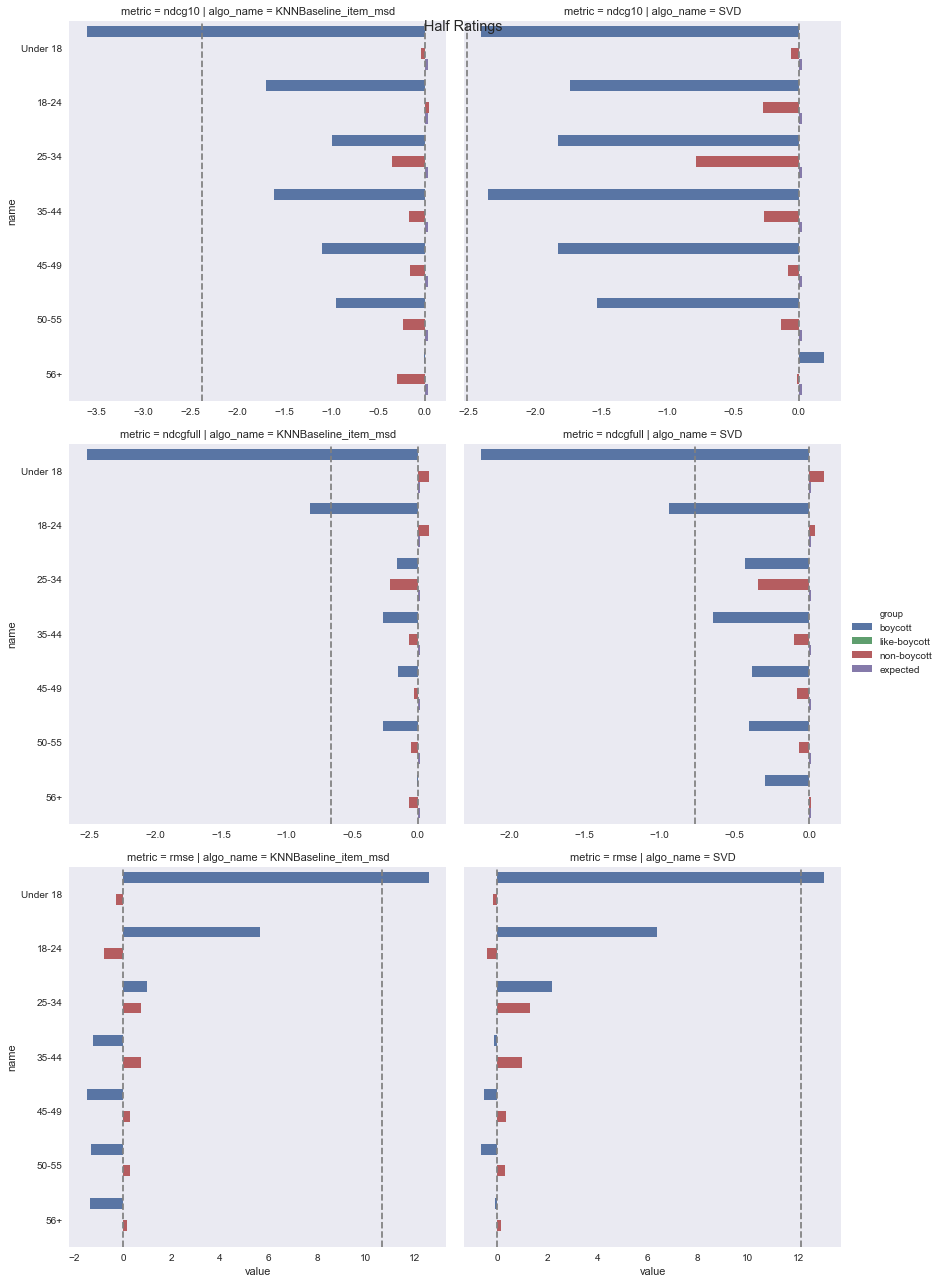

In [177]:
plot_all_three_scenarios(age_boycotts)

['percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']
['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_like-boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_boycott', 'percent_increase_ndcgfull_like-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_like-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']
['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_like-boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_boycott', 'percent_increase_ndcgfull_like-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_like-boycott', 'percent_increase

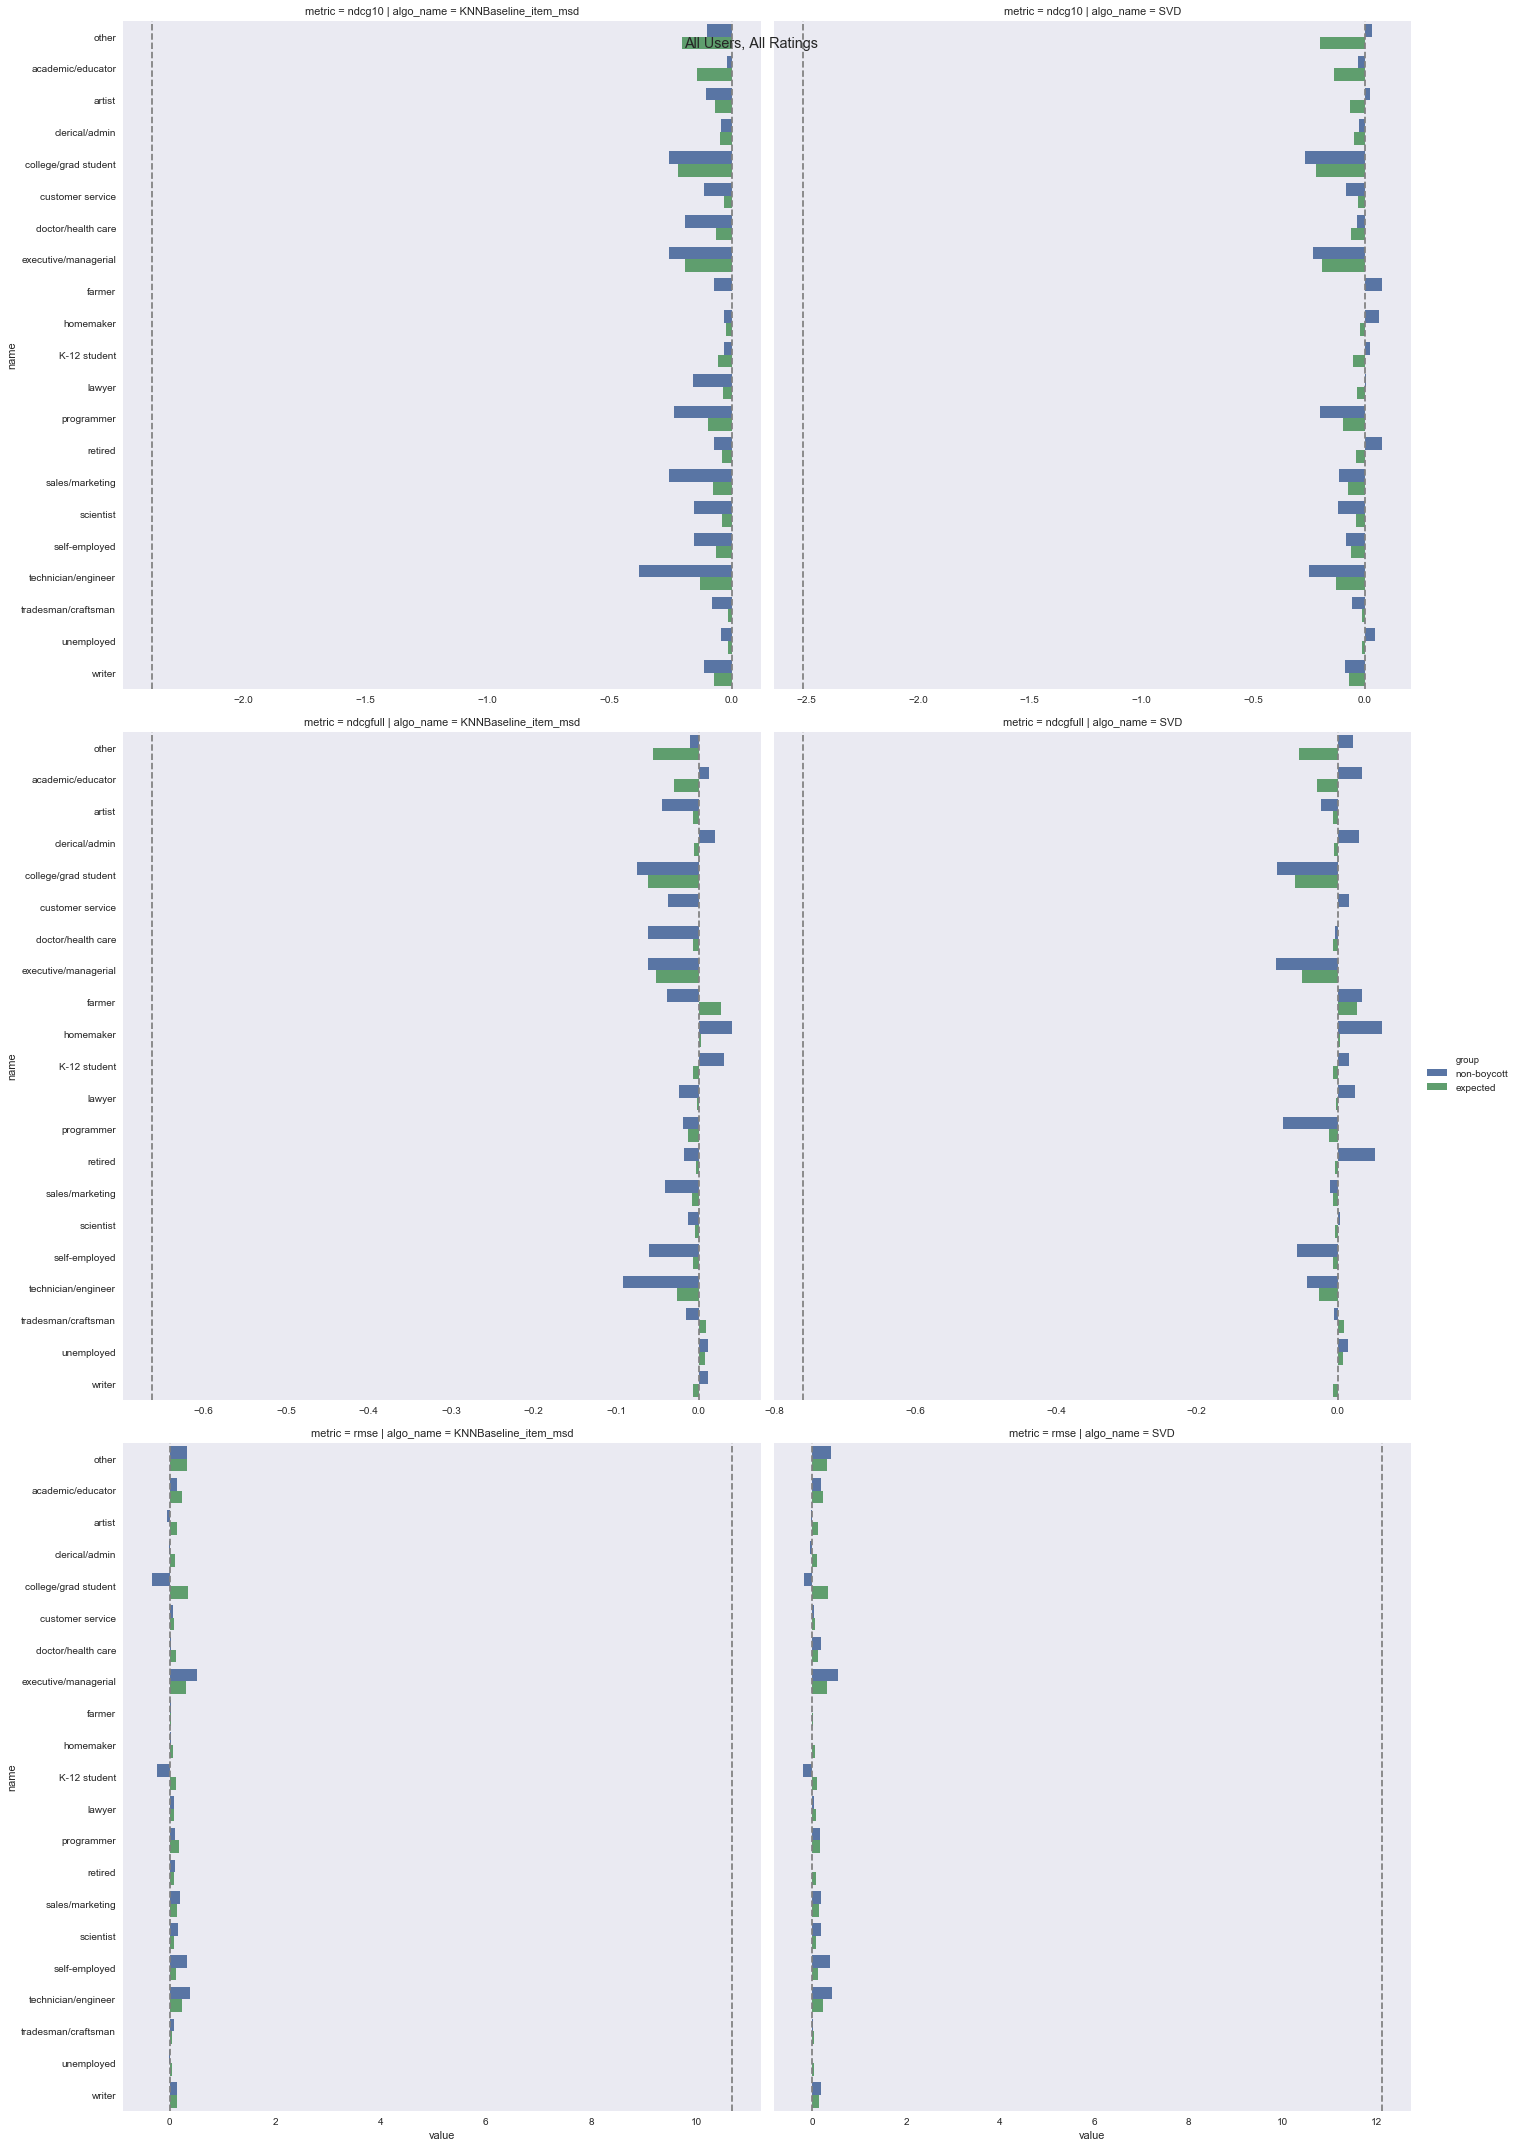

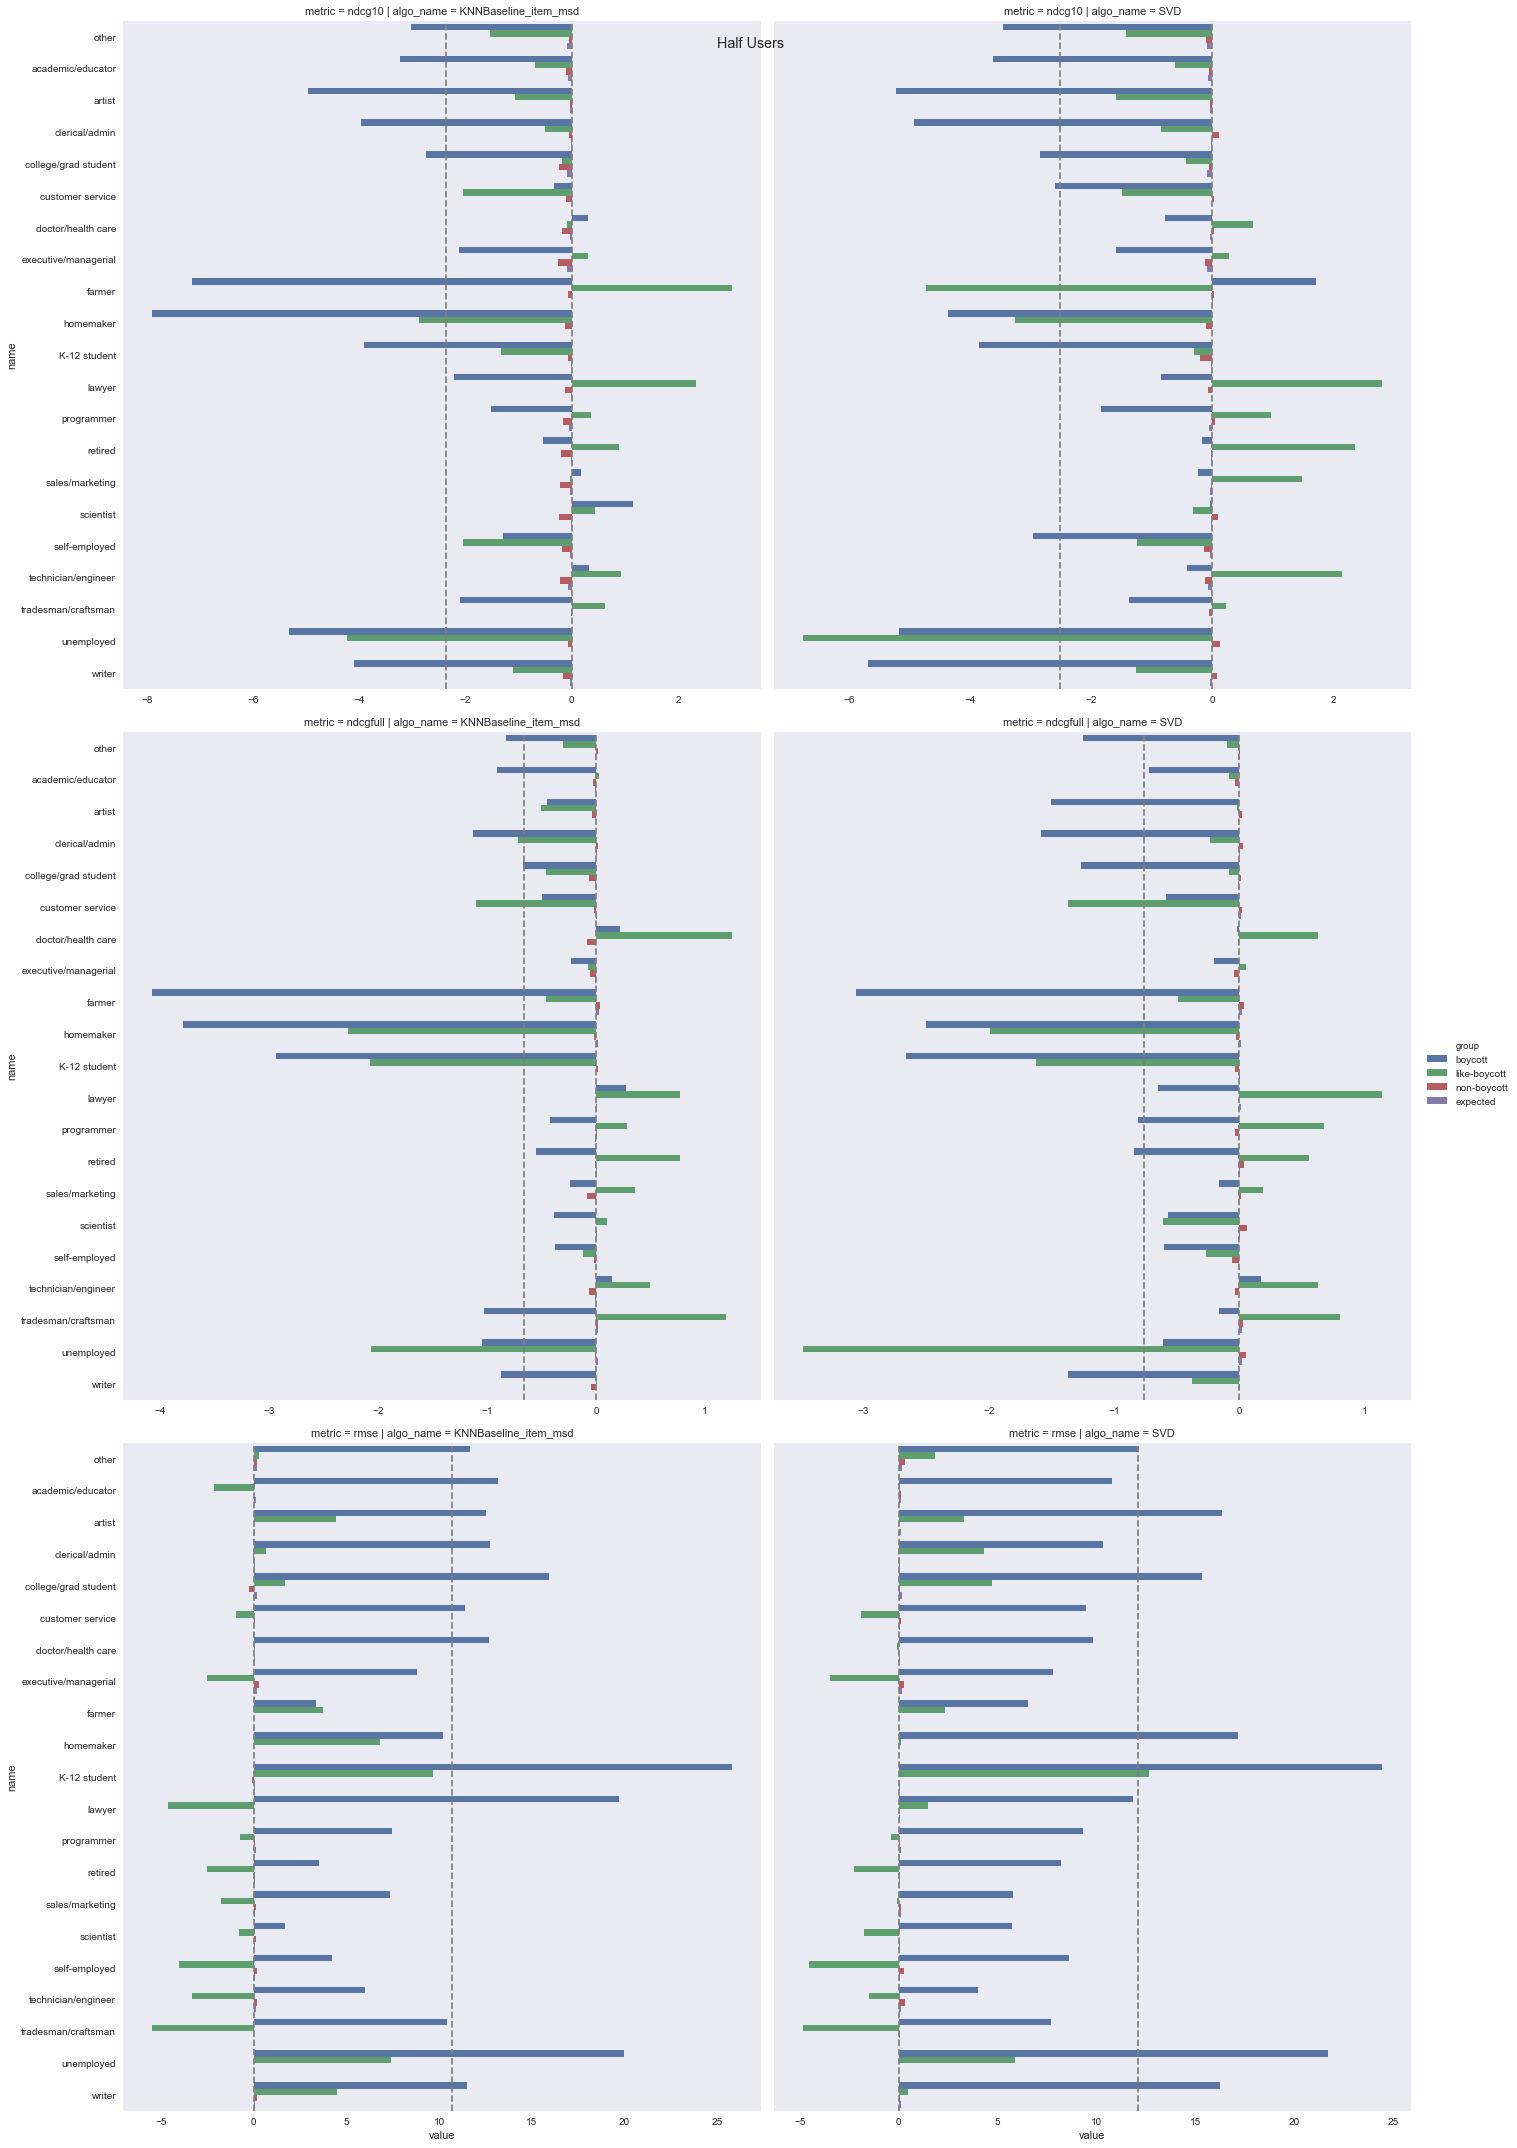

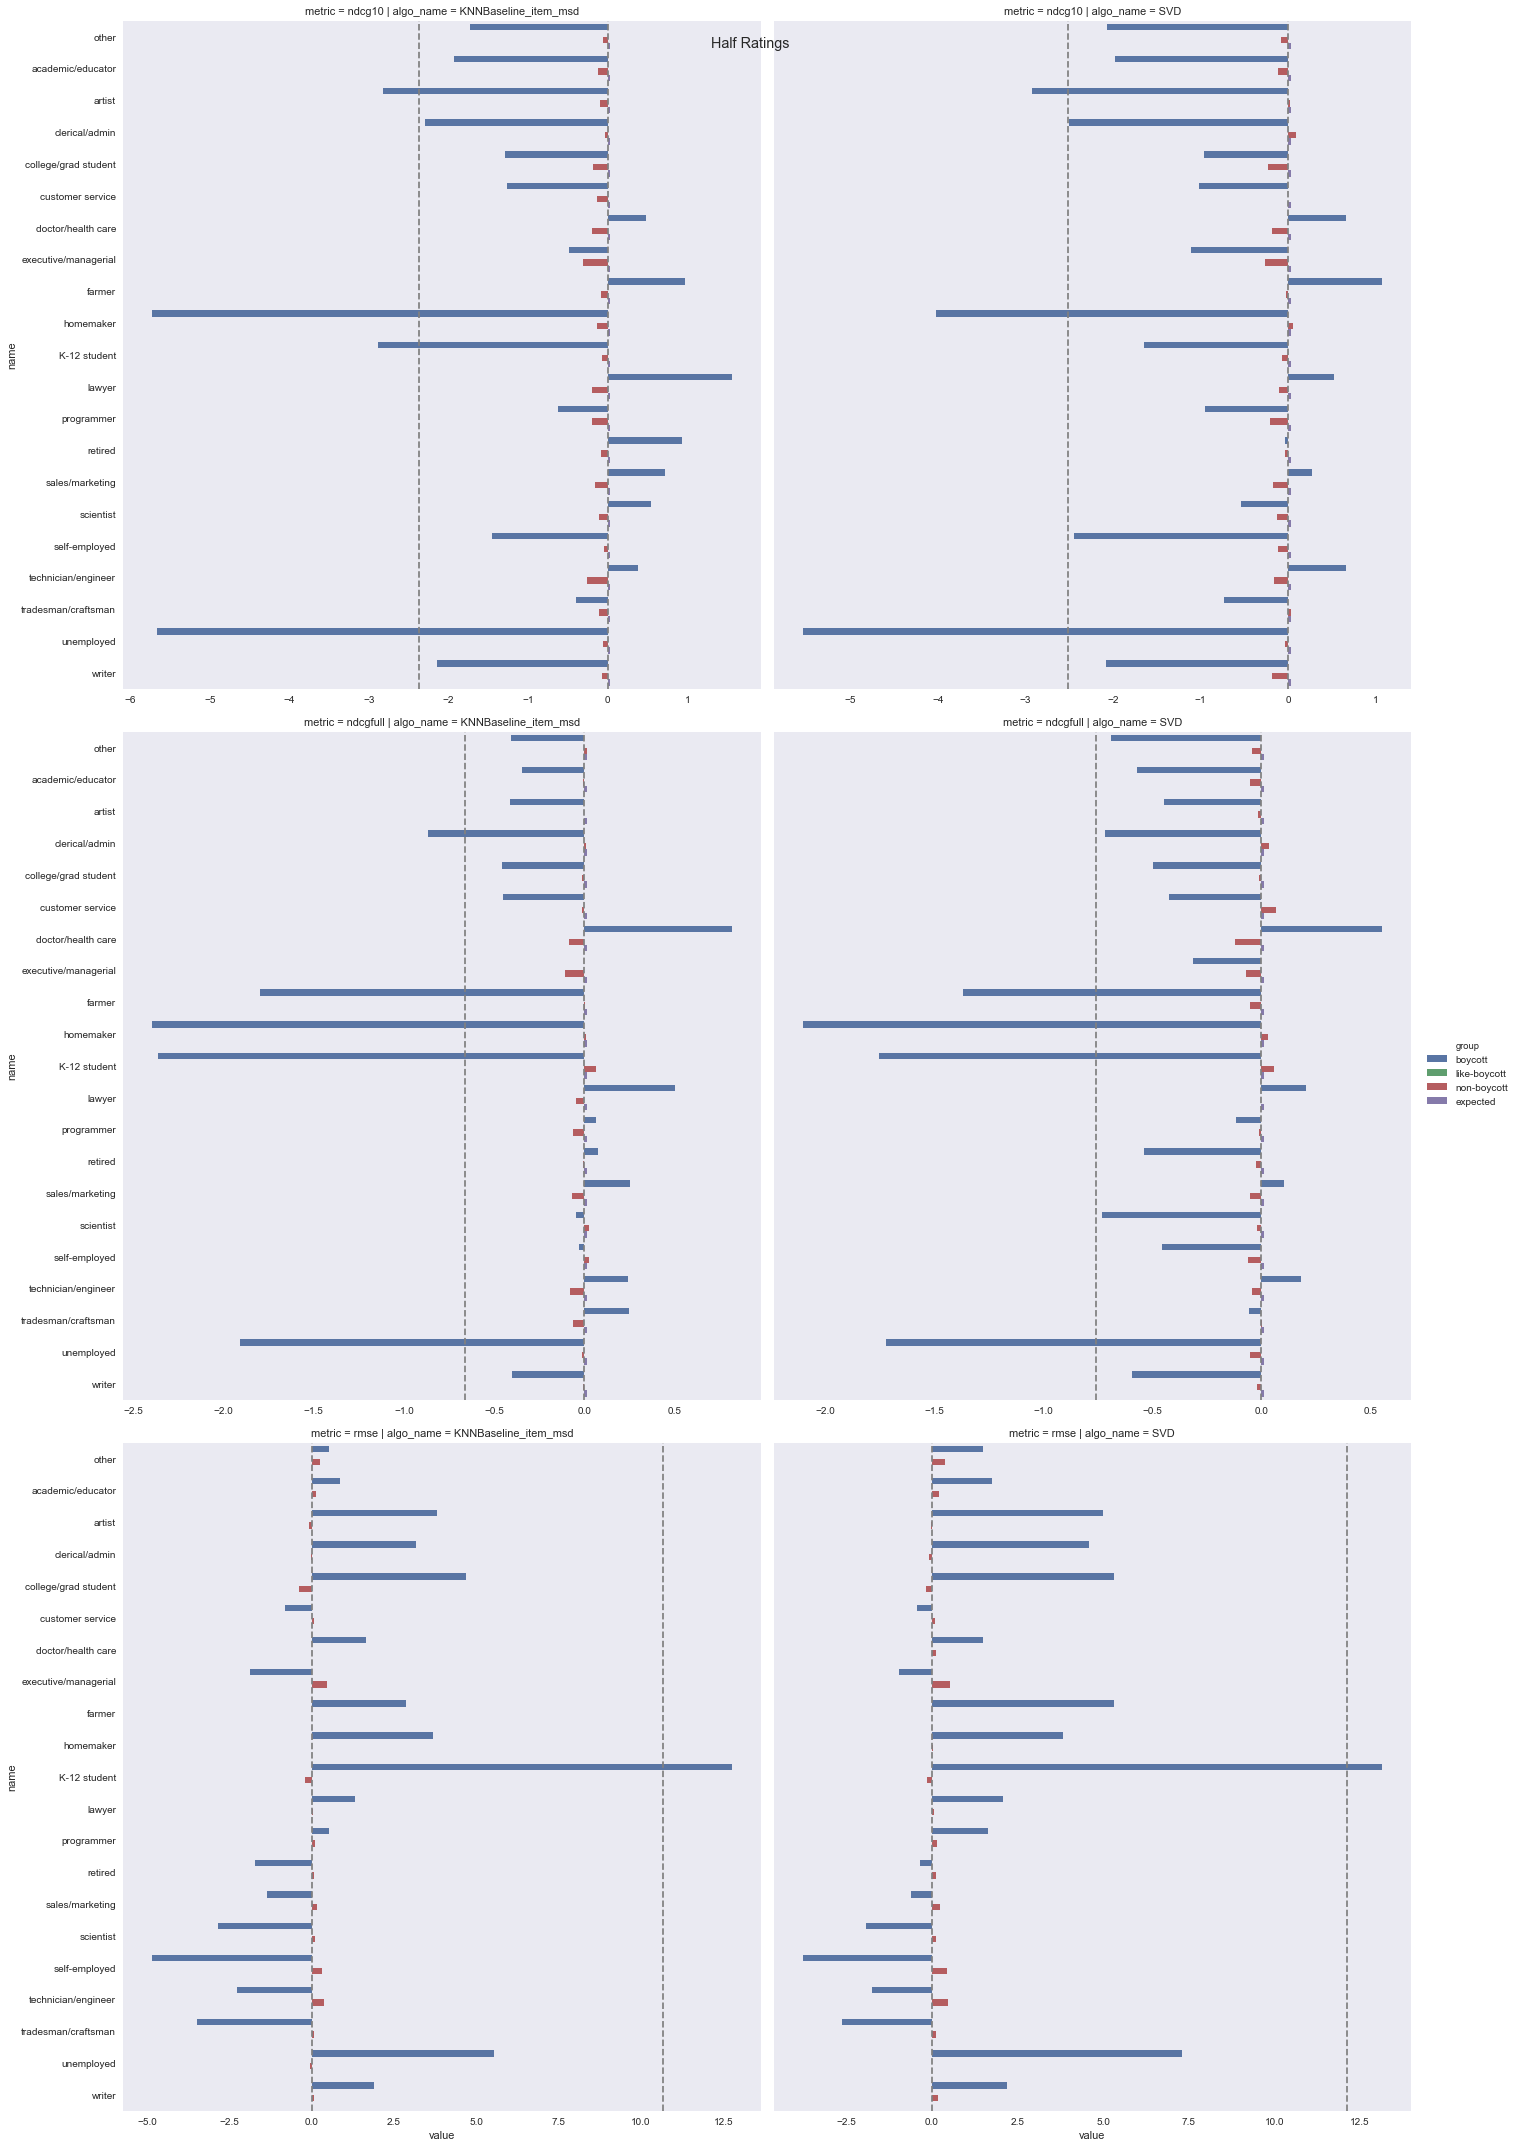

In [178]:
plot_all_three_scenarios(occupation_boycotts, size=10)

['percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']
['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_like-boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_boycott', 'percent_increase_ndcgfull_like-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_like-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']
['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_like-boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_boycott', 'percent_increase_ndcgfull_like-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_like-boycott', 'percent_increase

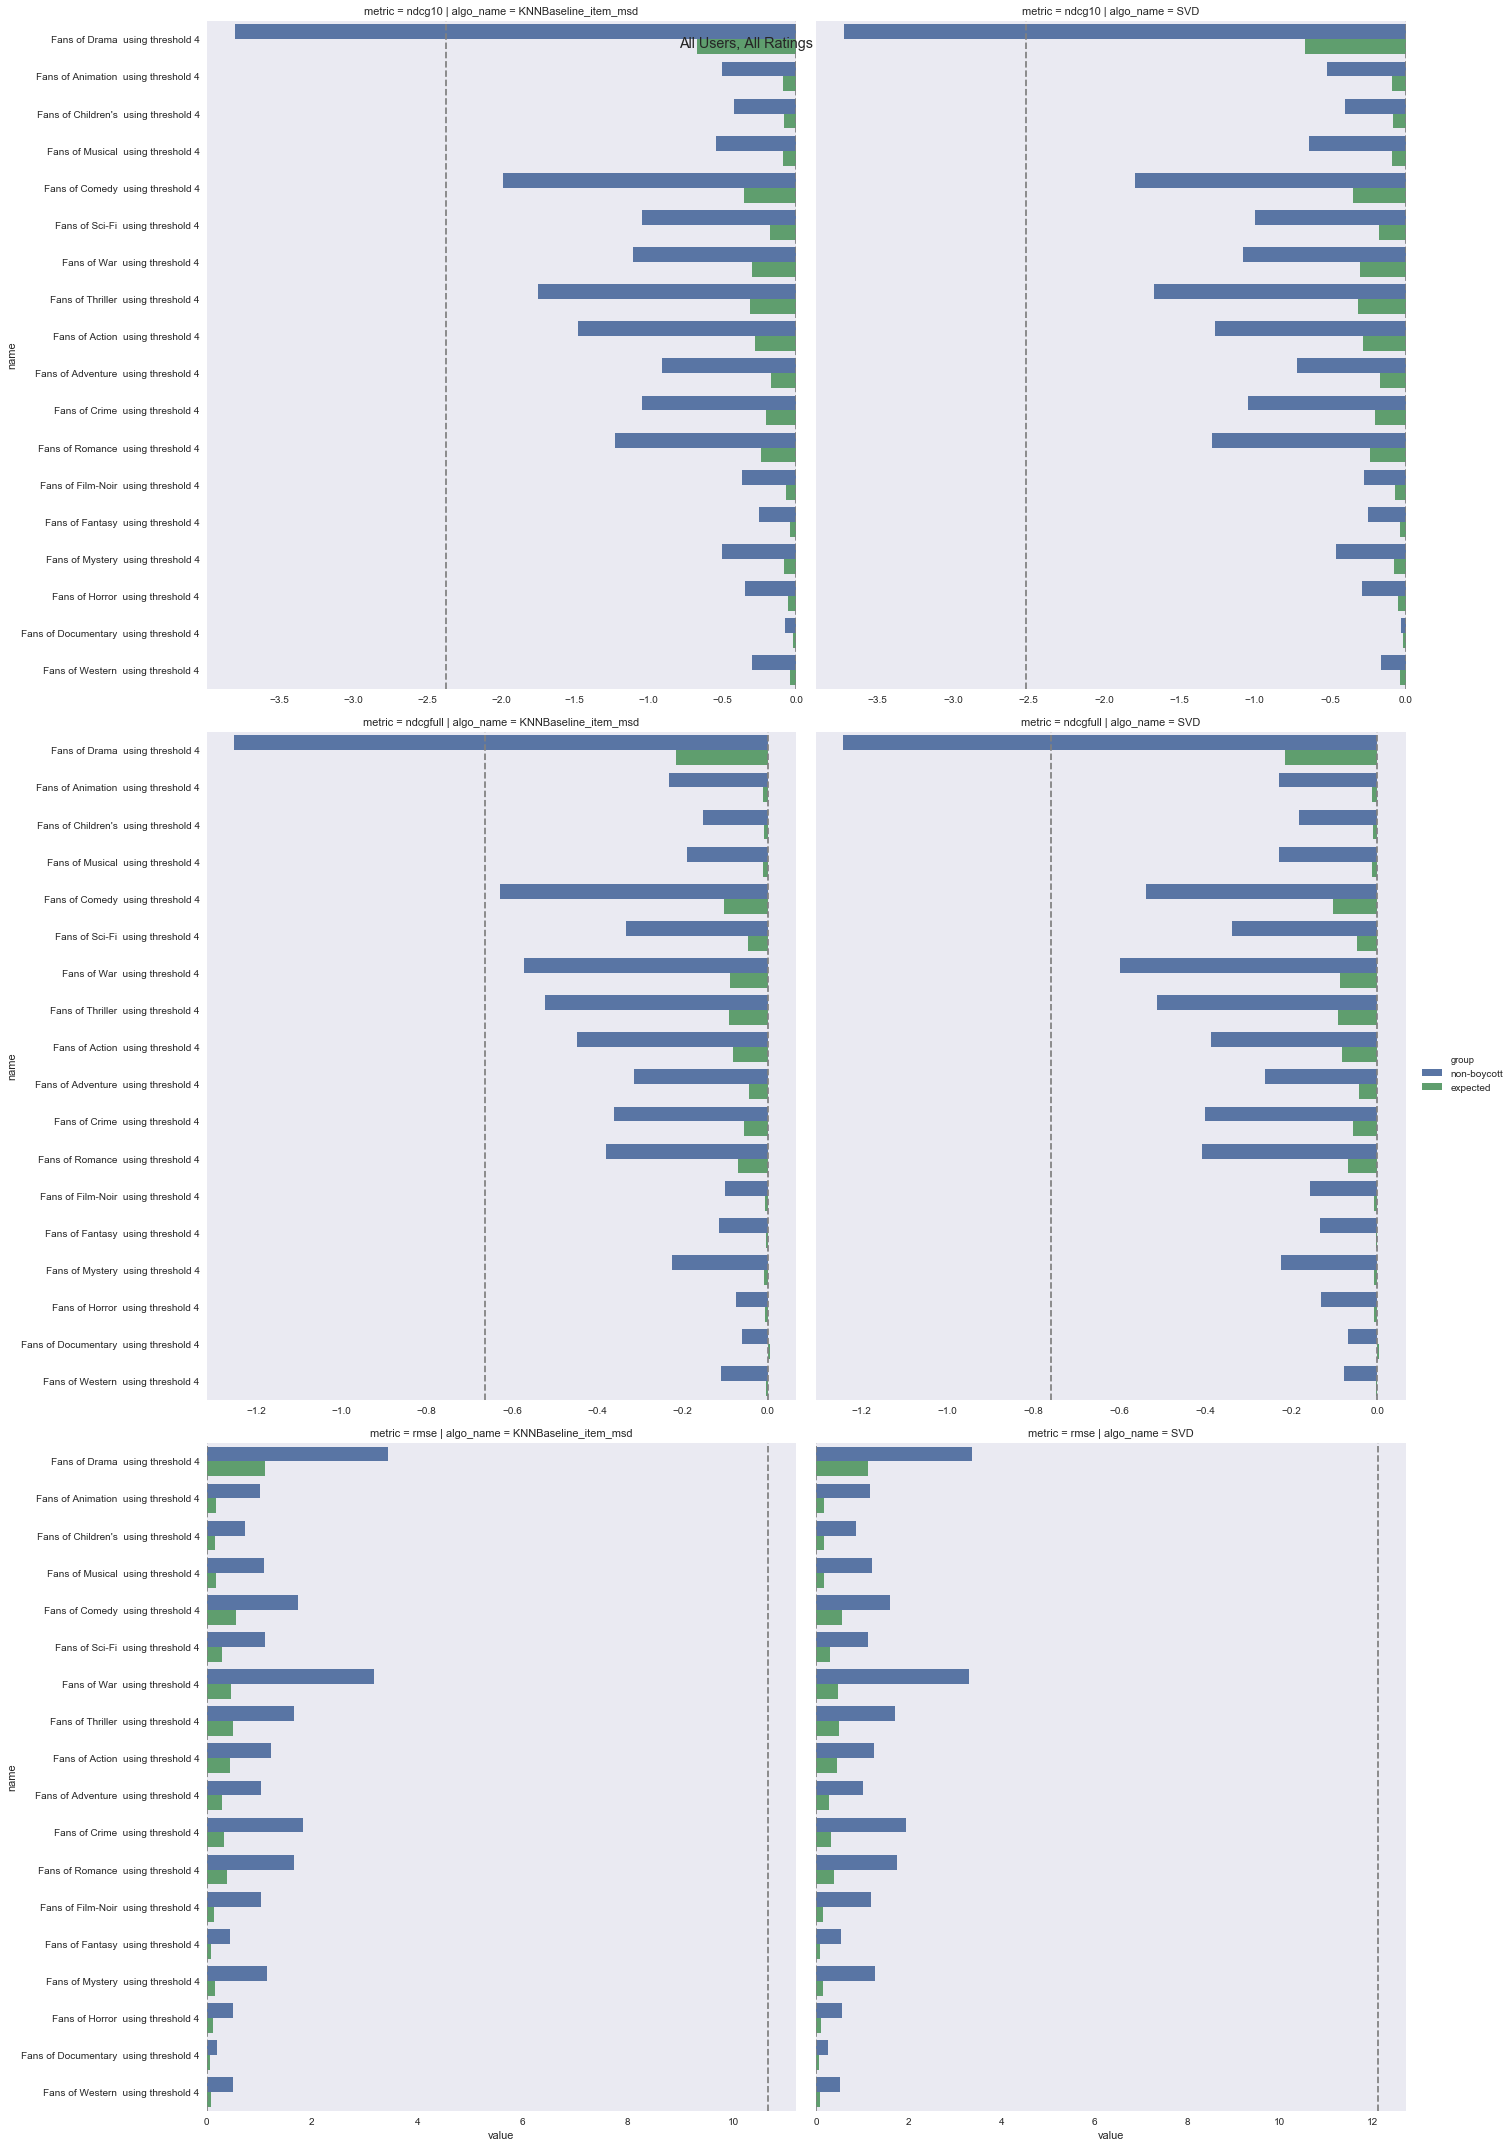

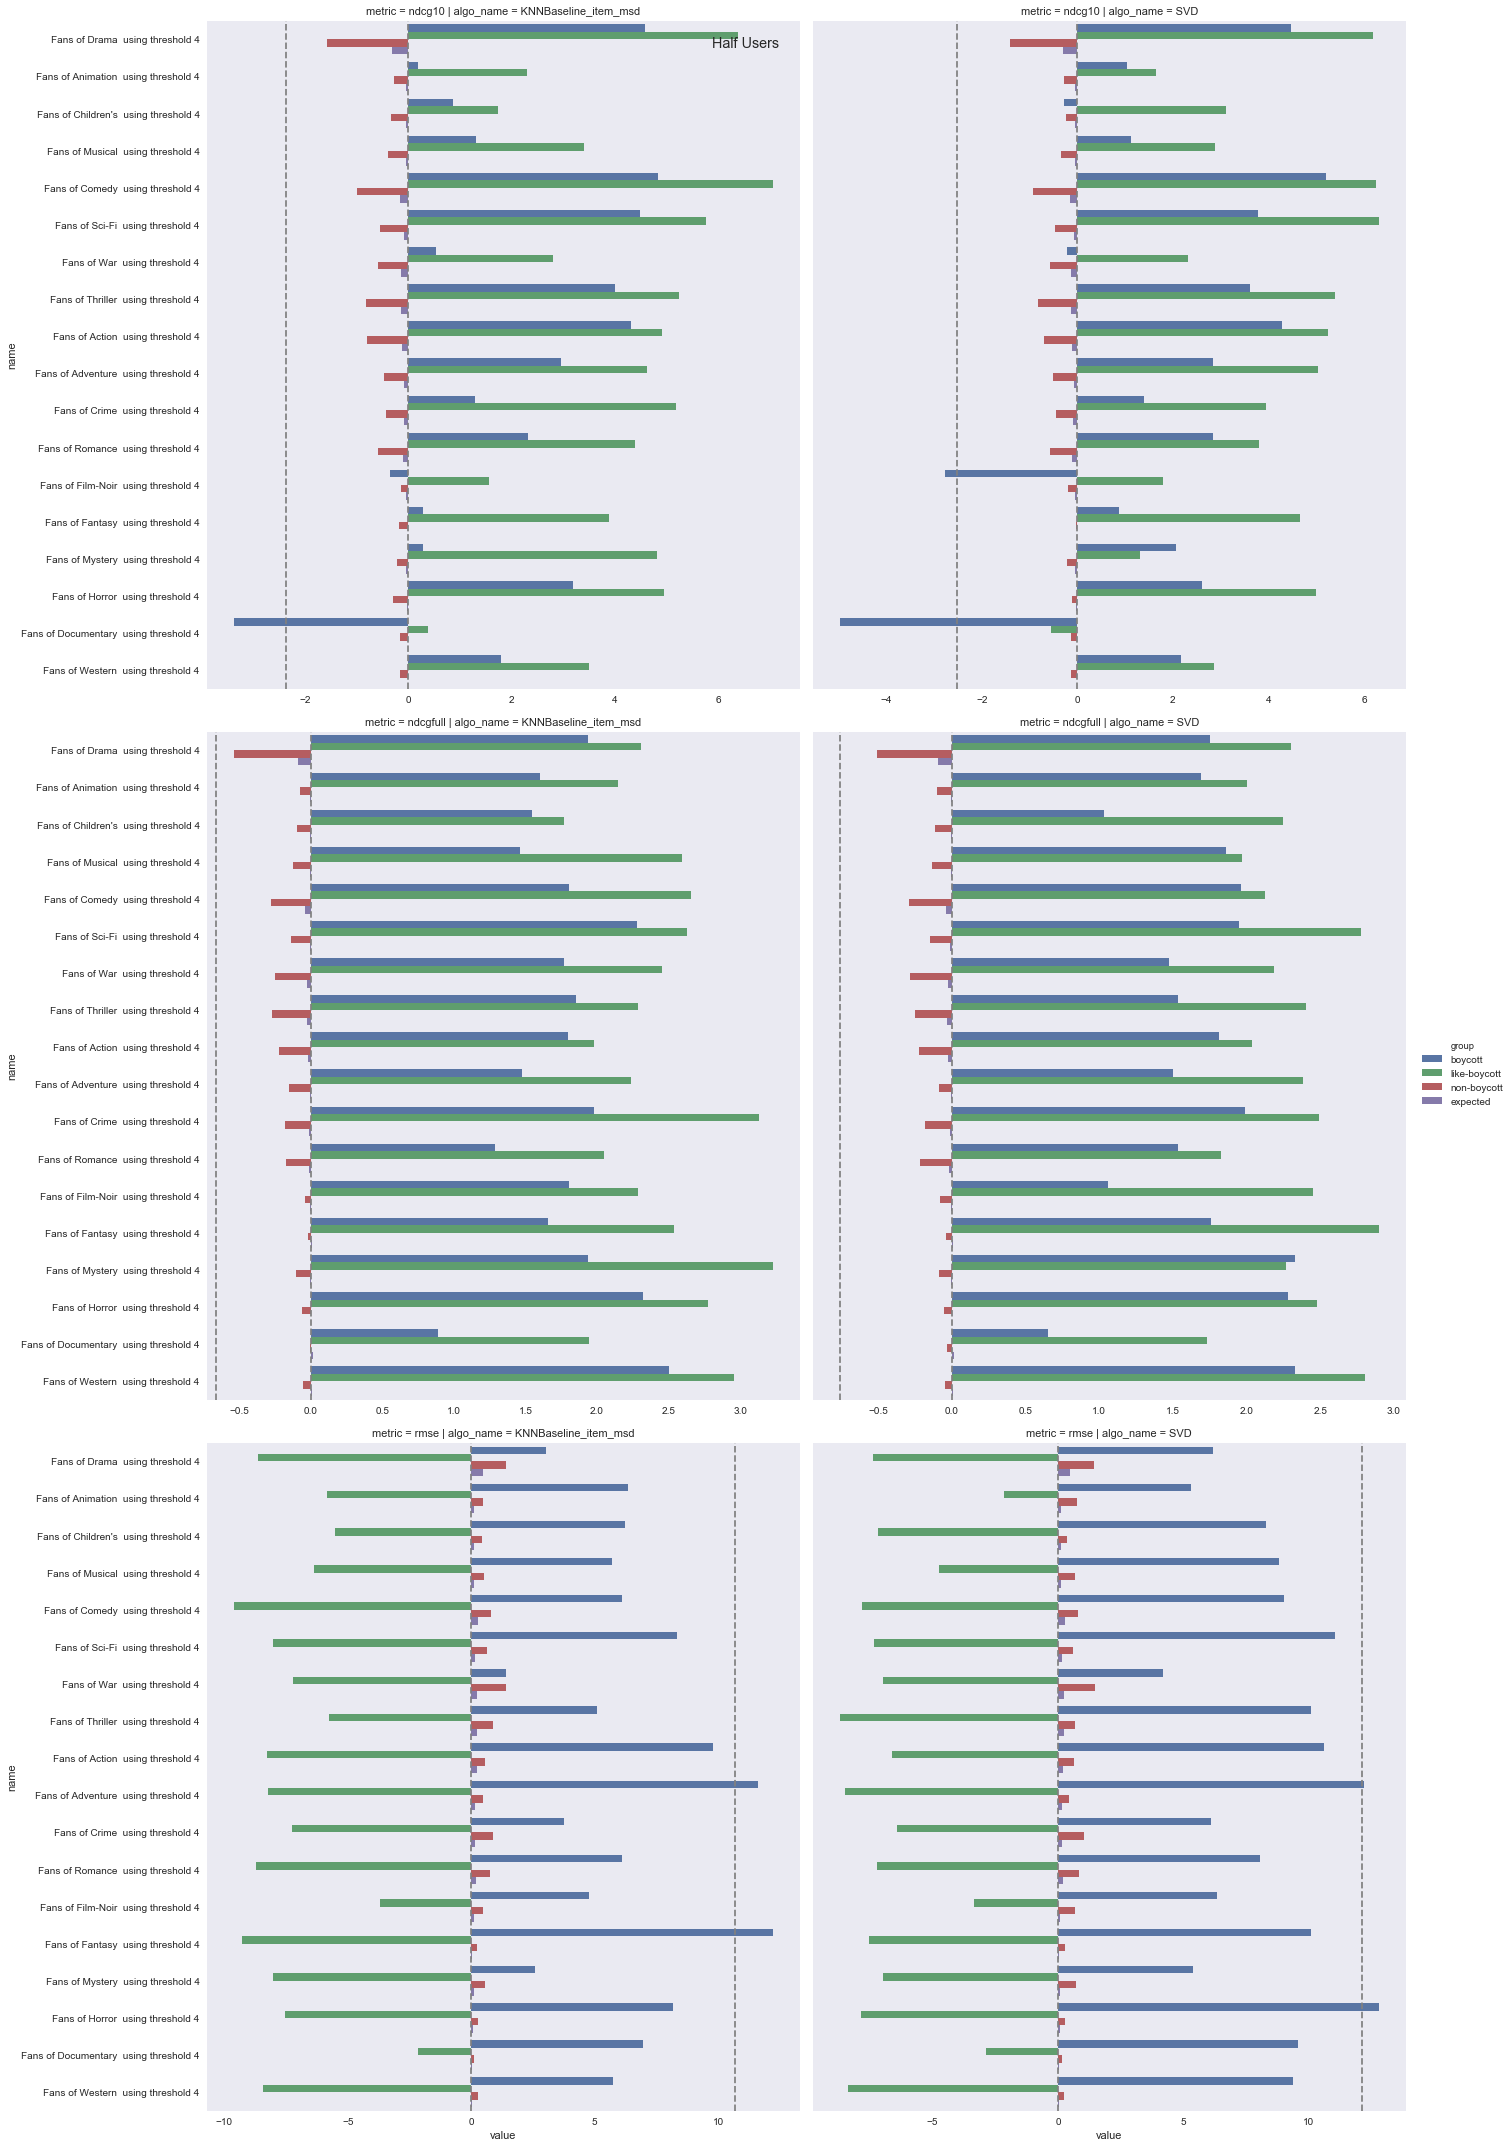

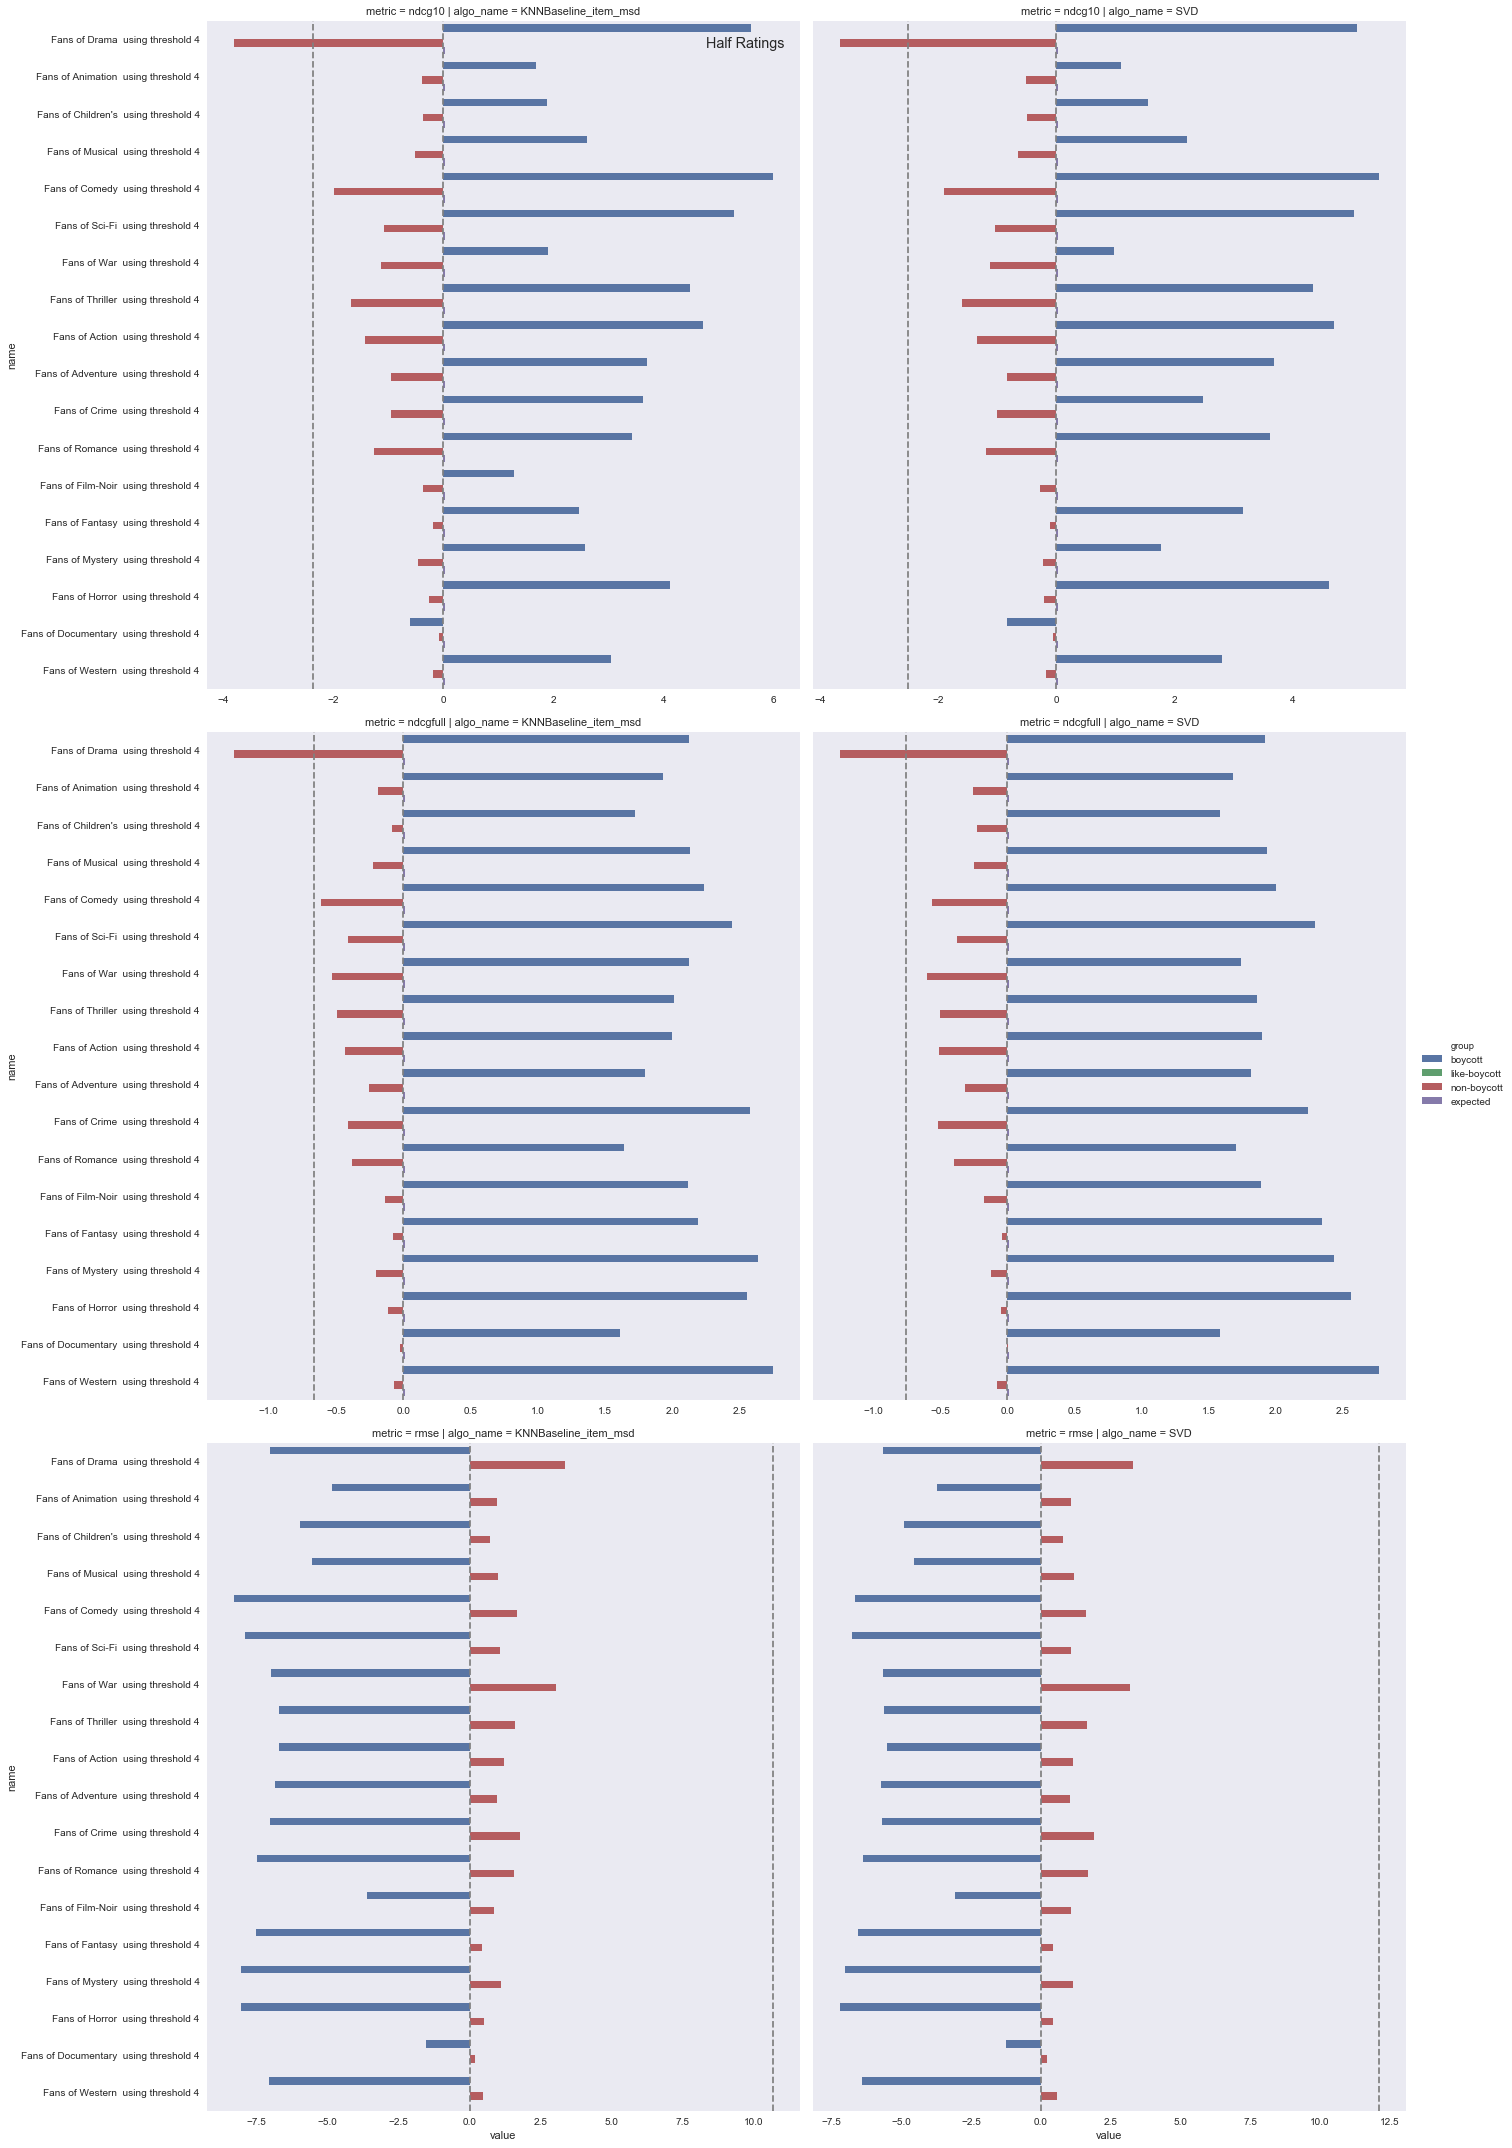

In [179]:
plot_all_three_scenarios(genre_boycotts, size=10)

### Looking at our real numbers
Full dataset precision@10 is 
SVD: 0.8026069529047541
KNN: 0.7999920231446164
w/ 3000 users boycotting:
KNN: 0.785440336
SVD: 0.784764938

In [180]:
prec_w_0 = {
    'SVD': 0.8026069529047541,
    'KNN': 0.7999920231446164
}
prec_w_3000 = {
    'SVD': 0.784764938,
    'KNN': 0.785440336
}

In [181]:
for n in ('SVD', 'KNN'):
    old = prec_w_0[n]
    new = prec_w_3000[n]
    err_rate_old = (1 - old) * 10
    err_rate_new = (1 - new) * 10
    delta = err_rate_new - err_rate_old
    print('err rate old vs new:', err_rate_old, err_rate_new, err_rate_new / err_rate_old)
    print('% change err rate', delta / err_rate_old * 100)
    percent_change = (new - old) / old * 100
    raw_change = new - old
    print(percent_change, '%', raw_change, 'raw')
    err_per_user = raw_change * 10
    print(err_per_user / err_rate_old * 100)
    
    err_per_1m = err_per_user * 1e6
    users_needed_to_see_err = 1 / err_per_user
    print('Error per user:', err_per_user)
    print('Error per 1m users:', err_per_1m)
    print(users_needed_to_see_err, 'users')

err rate old vs new: 1.9739304709524585 2.15235062 1.0903882642641665
% change err rate 9.03882642641665
-2.223007767398627 % -0.017842014904754122 raw
-9.038826426416637
Error per user: -0.17842014904754122
Error per 1m users: -178420.14904754123
-5.604748148335777 users
err rate old vs new: 2.000079768553836 2.1455966400000004 1.07275553392122
% change err rate 7.275553392121993
-1.8189790302428888 % -0.01455168714461641 raw
-7.275553392121982
Error per user: -0.1455168714461641
Error per 1m users: -145516.8714461641
-6.872055384794081 users
